## Chicago Crime Analysis
In this project, we explored ~6.9 million data of Chicago city crime since 2001. This project aims at exploring the data to gain some insights of the crime behavior from a variety aspects through using spark SQL and dataframe manipulation, data visualization, feature engineering, clustering ML algorithm and time series model.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"

#### 0.Data Gathering

In [0]:
# import urllib.request
# urllib.request.urlretrieve("https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD", "/tmp/chicagoCrimeData.csv")
# dbutils.fs.mv("file:/tmp/chicagoCrimeData.csv", "/FileStore/datasets/chicagoCrime.csv")
# urllib.request.urlretrieve("https://data.cityofchicago.org/api/views/igwz-8jzy/rows.csv?accessType=DOWNLOAD", "/tmp/geoLocationData.csv")
# dbutils.fs.mv("file:/tmp/geoLocationData.csv", "/FileStore/datasets/geoLocationData.csv")
display(dbutils.fs.ls("/FileStore/datasets/"))

path name size dbfs:/FileStore/datasets/chicagoCrime.csv chicagoCrime.csv 1771750630 dbfs:/FileStore/datasets/geoLocationData.csv geoLocationData.csv 2009107

In [0]:
df_crime = spark.read.load("/FileStore/datasets/chicagoCrime.csv", format='csv', header = True, inferSchema = True)
df_geo_full = spark.read.load("/FileStore/datasets/geoLocationData.csv", format='csv', header = True, inferSchema = True)

In [0]:
# the crime data shows some time-related and location-related data of a crime case, as well as crime type, detailed description, 
# administration-related codes, etc.
df_crime.show(5, vertical = True)

-RECORD 0------------------------------------
 ID                   | 10224738             
 Case Number          | HY411648             
 Date                 | 09/05/2015 01:30:... 
 Block                | 043XX S WOOD ST      
 IUCR                 | 0486                 
 Primary Type         | BATTERY              
 Description          | DOMESTIC BATTERY ... 
 Location Description | RESIDENCE            
 Arrest               | false                
 Domestic             | true                 
 Beat                 | 924                  
 District             | 9                    
 Ward                 | 12                   
 Community Area       | 61                   
 FBI Code             | 08B                  
 X Coordinate         | 1165074              
 Y Coordinate         | 1875917              
 Year                 | 2015                 
 Updated On           | 02/10/2018 03:50:... 
 Latitude             | 41.815117282         
 Longitude            | -87.669999

In [0]:
df_geo_full.show(5)

+--------------------+---------+----+--------+----------+----------+---------------+----------+---------------+-------------+
|            the_geom|PERIMETER|AREA|COMAREA_|COMAREA_ID|AREA_NUMBE|      COMMUNITY|AREA_NUM_1|     SHAPE_AREA|    SHAPE_LEN|
+--------------------+---------+----+--------+----------+----------+---------------+----------+---------------+-------------+
|MULTIPOLYGON (((-...|        0|   0|       0|         0|        35|        DOUGLAS|        35|4.60046211581E7|31027.0545098|
|MULTIPOLYGON (((-...|        0|   0|       0|         0|        36|        OAKLAND|        36|1.69139610408E7|19565.5061533|
|MULTIPOLYGON (((-...|        0|   0|       0|         0|        37|    FULLER PARK|        37|1.99167048692E7|25339.0897503|
|MULTIPOLYGON (((-...|        0|   0|       0|         0|        38|GRAND BOULEVARD|        38|4.84925031554E7|28196.8371573|
|MULTIPOLYGON (((-...|        0|   0|       0|         0|        39|        KENWOOD|        39|2.90717419283E7|23325.1

In [0]:
# We will need geo table to obtain the community name based on the community area (code) from crime table.
# First let's check null values for community area variable
df_crime.filter(df_crime['Community Area'].isNull()).count()

Out[6]: 613478

In [0]:
# combine two tables using inner join to drop those rows with null values
df_geo = df_geo_full.select(['AREA_NUMBE', 'COMMUNITY'])
df = df_crime.join(df_geo, df_crime['Community Area'] == df_geo['AREA_NUMBE'], 'inner')

In [0]:
df.show(5, vertical = True)

-RECORD 0------------------------------------
 ID                   | 10224738             
 Case Number          | HY411648             
 Date                 | 09/05/2015 01:30:... 
 Block                | 043XX S WOOD ST      
 IUCR                 | 0486                 
 Primary Type         | BATTERY              
 Description          | DOMESTIC BATTERY ... 
 Location Description | RESIDENCE            
 Arrest               | false                
 Domestic             | true                 
 Beat                 | 924                  
 District             | 9                    
 Ward                 | 12                   
 Community Area       | 61                   
 FBI Code             | 08B                  
 X Coordinate         | 1165074              
 Y Coordinate         | 1875917              
 Year                 | 2015                 
 Updated On           | 02/10/2018 03:50:... 
 Latitude             | 41.815117282         
 Longitude            | -87.669999

In [0]:
df.count()

Out[9]: 6893314

In [0]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- AREA_NUMBE: integer (nullable = true)
 |-- COMMUNITY: string (nullable = true)



#### 1.Data Cleaning

In [0]:
# Perform data cleaning to tranform Date variable into different useful time-related variables. 
from pyspark.sql.functions import date_format, to_date, col

udf_date_to_day = udf(lambda s: s[:10])
udf_date_to_month = udf(lambda s: s[0:2])
udf_date_to_year_month = udf(lambda s: s[6:10] + '/' + s[0:2])

df = df.withColumn('Day_str', udf_date_to_day('Date'))
df = df.withColumn('Day', to_date('Day_str', 'MM/dd/yyyy'))
df = df.withColumn('DayofWeek', date_format('Day', 'E'))
df = df.withColumn('Month', udf_date_to_month('Date').cast('int'))
df = df.withColumn('Year/Month', udf_date_to_year_month('Date'))

# Transform datetime into hour in 24-hour format
def date_to_hour(s):
  if s[-2:] == 'PM':
    if s[11:13] == '12':
      return '12'
    else:
      return int(s[11:13]) + 12
  else:
    if s[11:13] == '12':
      return '0'
    else:
      return int(s[11:13])

udf_date_to_hour = udf(lambda s: date_to_hour(s))
df = df.withColumn('Hour', udf_date_to_hour('Date').cast('int'))

In [0]:
# Check if data cleaning is done properly.
df.show(1, vertical = True)

-RECORD 0------------------------------------
 ID                   | 10224738             
 Case Number          | HY411648             
 Date                 | 09/05/2015 01:30:... 
 Block                | 043XX S WOOD ST      
 IUCR                 | 0486                 
 Primary Type         | BATTERY              
 Description          | DOMESTIC BATTERY ... 
 Location Description | RESIDENCE            
 Arrest               | false                
 Domestic             | true                 
 Beat                 | 924                  
 District             | 9                    
 Ward                 | 12                   
 Community Area       | 61                   
 FBI Code             | 08B                  
 X Coordinate         | 1165074              
 Y Coordinate         | 1875917              
 Year                 | 2015                 
 Updated On           | 02/10/2018 03:50:... 
 Latitude             | 41.815117282         
 Longitude            | -87.669999

#### 2.OLAP

Display the number of crimes for different crime categories. Top 5 of crimes that occurred most frequently are Theft, Battery, Criminal damage, Narcotics and Assault (from high to low in frequency).

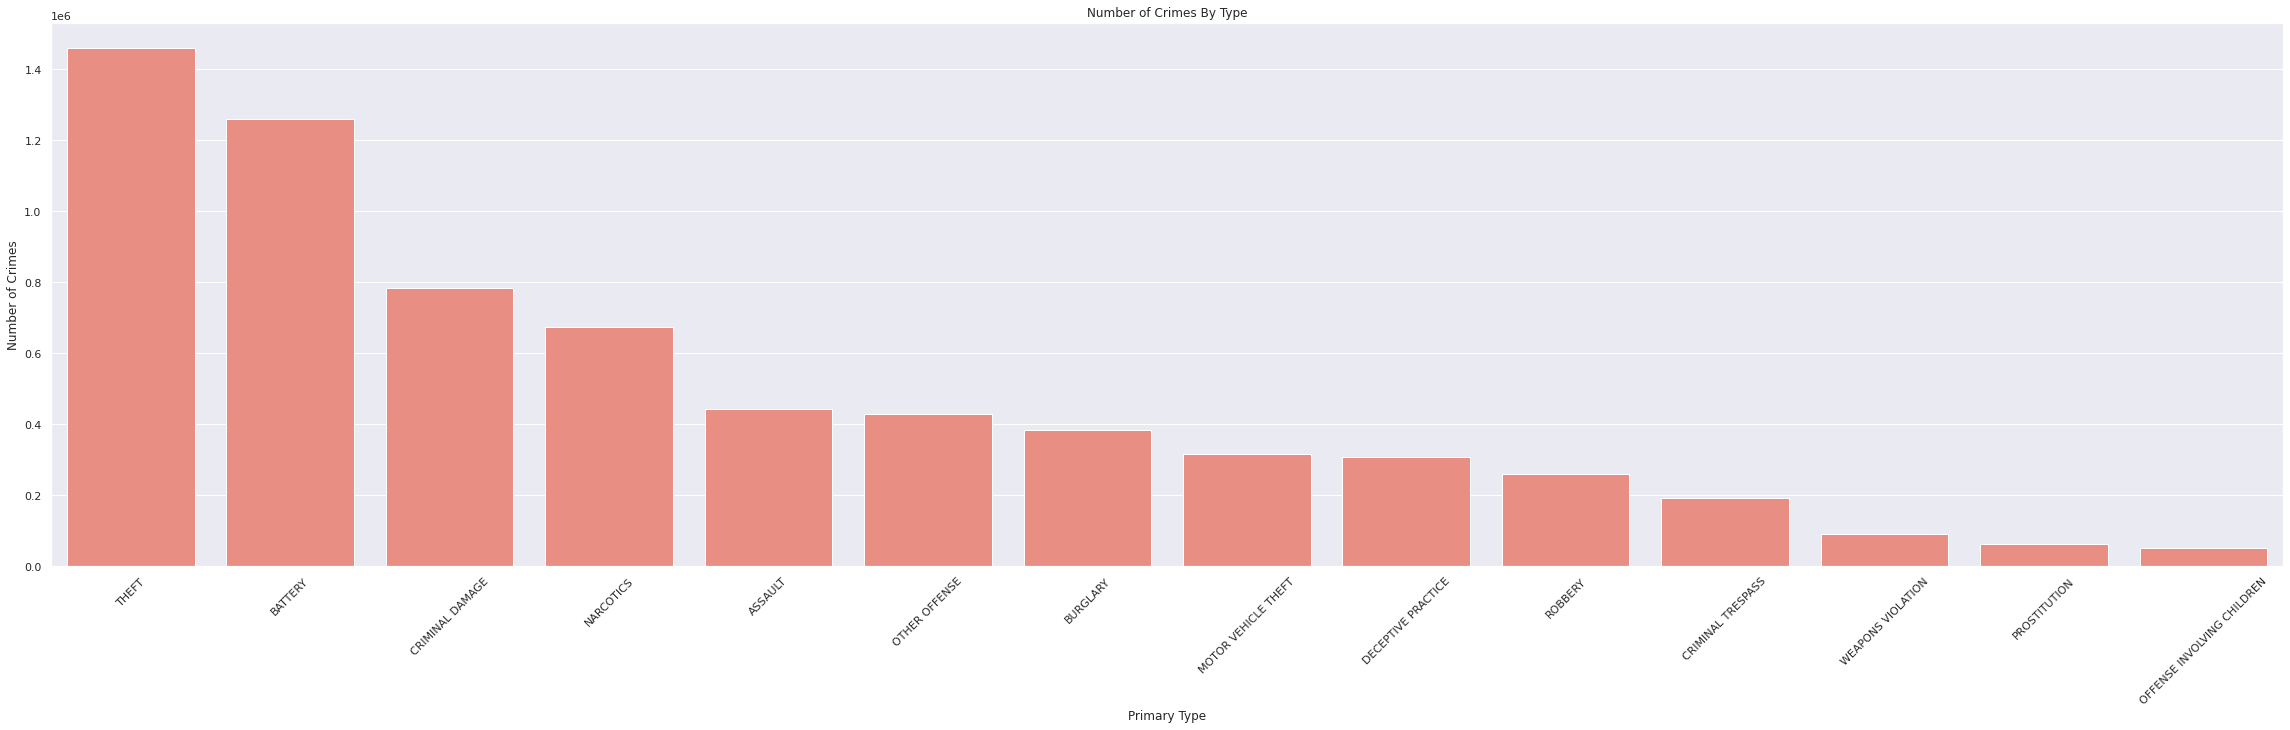

In [0]:
crimeType = df.groupBy('Primary Type').count().orderBy('count', ascending=False)
crimeType_pd = crimeType.toPandas()

sns.set(rc = {'figure.figsize':(40, 10)})
sns.barplot(x = 'Primary Type', y = 'count', color = 'Salmon', 
            dodge = False, data = crimeType_pd[crimeType_pd['count'] > 50000]).set(title = 'Number of Crimes By Type')
plt.ylabel('Number of Crimes')
plt.xticks(rotation = 45)
plt.show()

Display the number of crimes for different districts.
1. We first rank number of crimes per district code, as shown in the first chart below. However, district code may not make sense to people.
2. We also rank number of crimes per community area where we only show those areas with total number of crime cases larger than 150,000. Austin, North Side, and South Shore are the top 3 areas that observed the most crime cases.

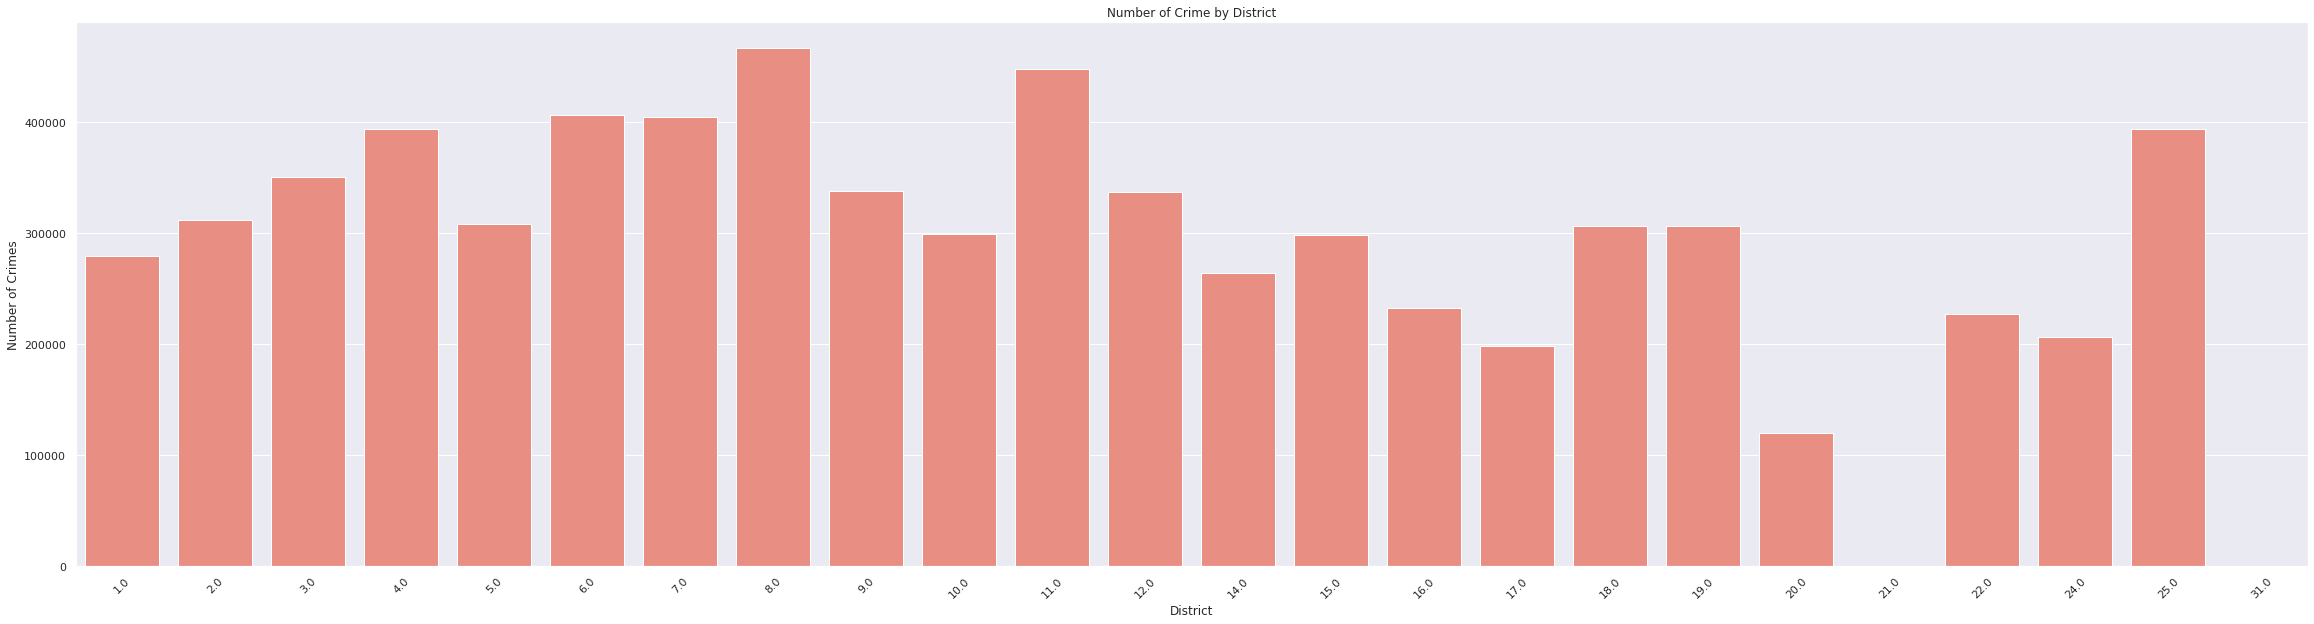

In [0]:
crimeDistrict = df.groupBy('District').count().orderBy('count', ascending = False)
crimeDistrict_pd = crimeDistrict.toPandas()

sns.set(rc = {'figure.figsize':(40, 10)})
sns.barplot(x = 'District', y = 'count', dodge = False, color = 'Salmon', data = crimeDistrict_pd).set(title = 'Number of Crime by District')
plt.ylabel('Number of Crimes')
plt.xticks(rotation = 45)
plt.show()

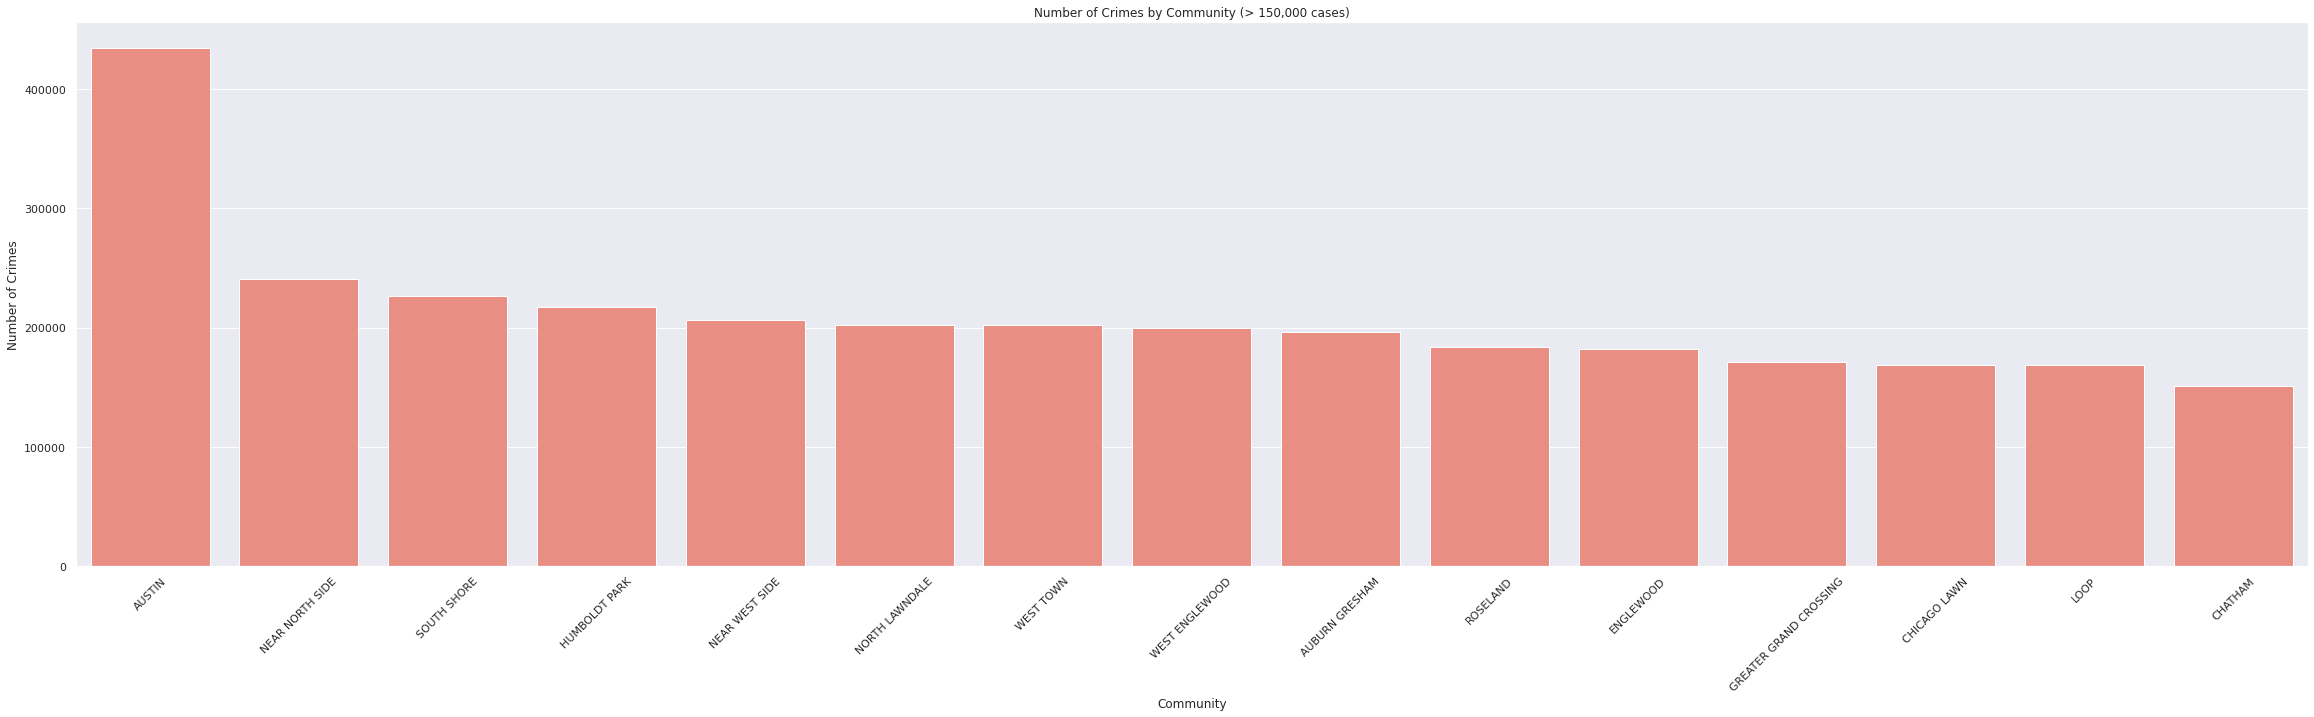

In [0]:
crimeCommunity = df.groupBy('Community').count().orderBy('count', ascending = False)
crimeCommunity_pd = crimeCommunity.toPandas()

sns.set(rc = {'figure.figsize':(40, 10)})
sns.barplot(x = 'Community', y = 'count', color = 'Salmon', 
            dodge = False, data = crimeCommunity_pd[crimeCommunity_pd['count'] > 150000]).set(title = 'Number of Crimes by Community (> 150,000 cases)')
                                                                                   
plt.ylabel('Number of Crimes')
plt.xticks(rotation = 45)                                                                                  
plt.show()

Display the number of crimes on each weekend within the downtow area.
For an approximation, we cropped an area on Google map to roughly determine the coordinates of Chicago downtown area and plot the number of crimes on every weekend since 2001. The crime behavior is pretty stable before 2016. During the first quarter of 2020, the crime cases dropped to the historically lowest level, which is probably due the breakout of pandemic. However, on Saturday, 05/30/2020, the crime cases climbed to 156 on that day, which is the historical high. On this day, massive protests occurred at Chicago downtown for the killing of George Floyd.

In [0]:
x1, x2 = 41.889093, 41.877722
y1, y2 = -87.614084, -87.641453
downtown_filter = (df['Latitude'] <= x1) & (df['Latitude'] >= x2) & (df['Longitude'] <= y1) & (df['Longitude'] >= y2)
crimeWeekend = df.filter(downtown_filter & ((df['DayofWeek'] == 'Sun') | (df['DayofWeek'] == 'Sat'))).groupBy('Day').count().orderBy('Day')

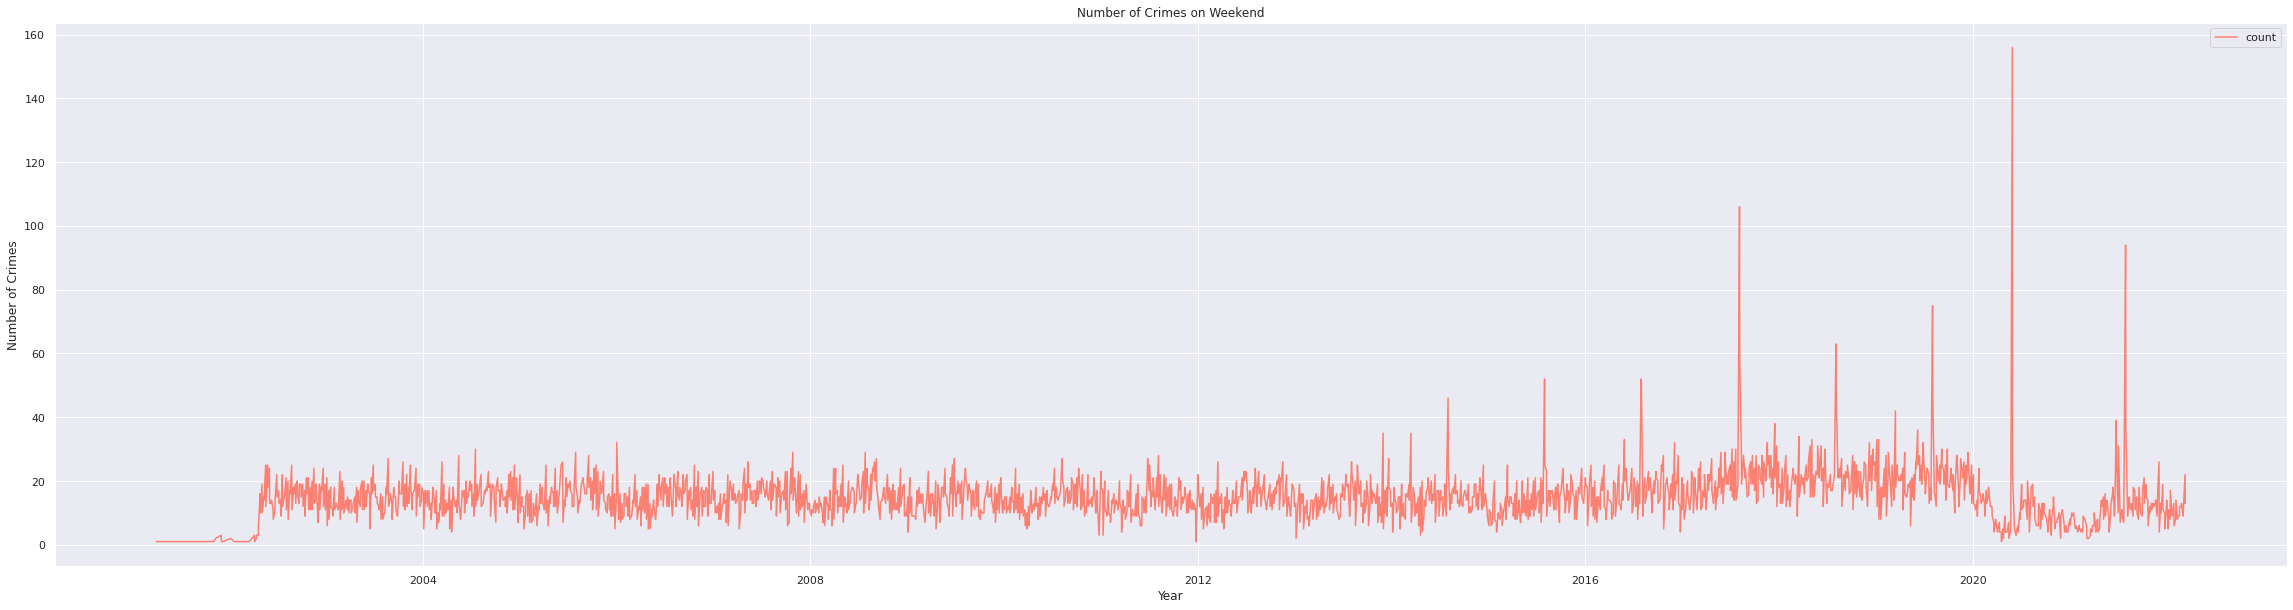

In [0]:
crimeWeekend_pd = crimeWeekend.toPandas()
crimeWeekend_pd.plot.line(x = 'Day', y = 'count', color = 'Salmon', title = 'Number of Crimes on Weekend')
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
plt.show()

In [0]:
# Look at the top 10 Sundays that witnessed the most crimes in history
crimeWeekend_pd.sort_values(by = 'count', ascending = False).iloc[:10,:]

Day 
 count 
 
 
 
 
 1913 
 2020-05-30 
 156 
 
 
 1619 
 2017-08-05 
 106 
 
 
 2035 
 2021-07-31 
 94 
 
 
 1827 
 2019-08-03 
 75 
 
 
 1723 
 2018-08-04 
 63 
 
 
 1620 
 2017-08-06 
 58 
 
 
 1409 
 2015-08-01 
 52 
 
 
 1513 
 2016-07-30 
 52 
 
 
 1514 
 2016-07-31 
 51 
 
 
 1724 
 2018-08-05 
 47

In [0]:
# look up the crime cases at the beginning of pandemic
date_filter = (crimeWeekend_pd['Day'] >= pd.to_datetime('2020-03-01')) & (crimeWeekend_pd['Day'] <= pd.to_datetime('2020-06-01'))
crimeWeekend_pd[date_filter]

Day 
 count 
 
 
 
 
 1888 
 2020-03-01 
 18 
 
 
 1889 
 2020-03-07 
 13 
 
 
 1890 
 2020-03-08 
 12 
 
 
 1891 
 2020-03-14 
 12 
 
 
 1892 
 2020-03-15 
 9 
 
 
 1893 
 2020-03-21 
 7 
 
 
 1894 
 2020-03-22 
 4 
 
 
 1895 
 2020-03-28 
 8 
 
 
 1896 
 2020-03-29 
 7 
 
 
 1897 
 2020-04-04 
 4 
 
 
 1898 
 2020-04-05 
 5 
 
 
 1899 
 2020-04-11 
 7 
 
 
 1900 
 2020-04-12 
 4 
 
 
 1901 
 2020-04-18 
 4 
 
 
 1902 
 2020-04-19 
 1 
 
 
 1903 
 2020-04-25 
 5 
 
 
 1904 
 2020-04-26 
 2 
 
 
 1905 
 2020-05-02 
 9 
 
 
 1906 
 2020-05-03 
 4 
 
 
 1907 
 2020-05-09 
 4 
 
 
 1908 
 2020-05-10 
 4 
 
 
 1909 
 2020-05-16 
 7 
 
 
 1910 
 2020-05-17 
 2 
 
 
 1911 
 2020-05-23 
 4 
 
 
 1912 
 2020-05-24 
 6 
 
 
 1913 
 2020-05-30 
 156 
 
 
 1914 
 2020-05-31 
 22

Based on data from 2015 to 2018, we analyzed the number of crimes per month and observed strong seasonality: crimes cases increase at the first half of the year and reach to peak during summer time (June, July and August) and then decline towards the end of year probably due to holiday seasons. Feburary sees least frequent cases probably because Feburary itself includes less number of days compared to other months. This observation is consistent with our understanding that those who conducted crimes are the same as others, who are more active when the weather is getting warmer. This definitely has an adverse impact on local business as summer time is also when local business is the most active and prosperous.

In [0]:
crimePerMonthPerYear = df.filter((df['Year'] <= 2018) & (df['Year'] >= 2015)).groupBy('Year/Month').count()
crimePerMonthPerYear.show(5)

+----------+-----+
|Year/Month|count|
+----------+-----+
|   2017/01|22132|
|   2018/05|24734|
|   2017/12|21101|
|   2015/11|20590|
|   2017/09|22846|
+----------+-----+
only showing top 5 rows



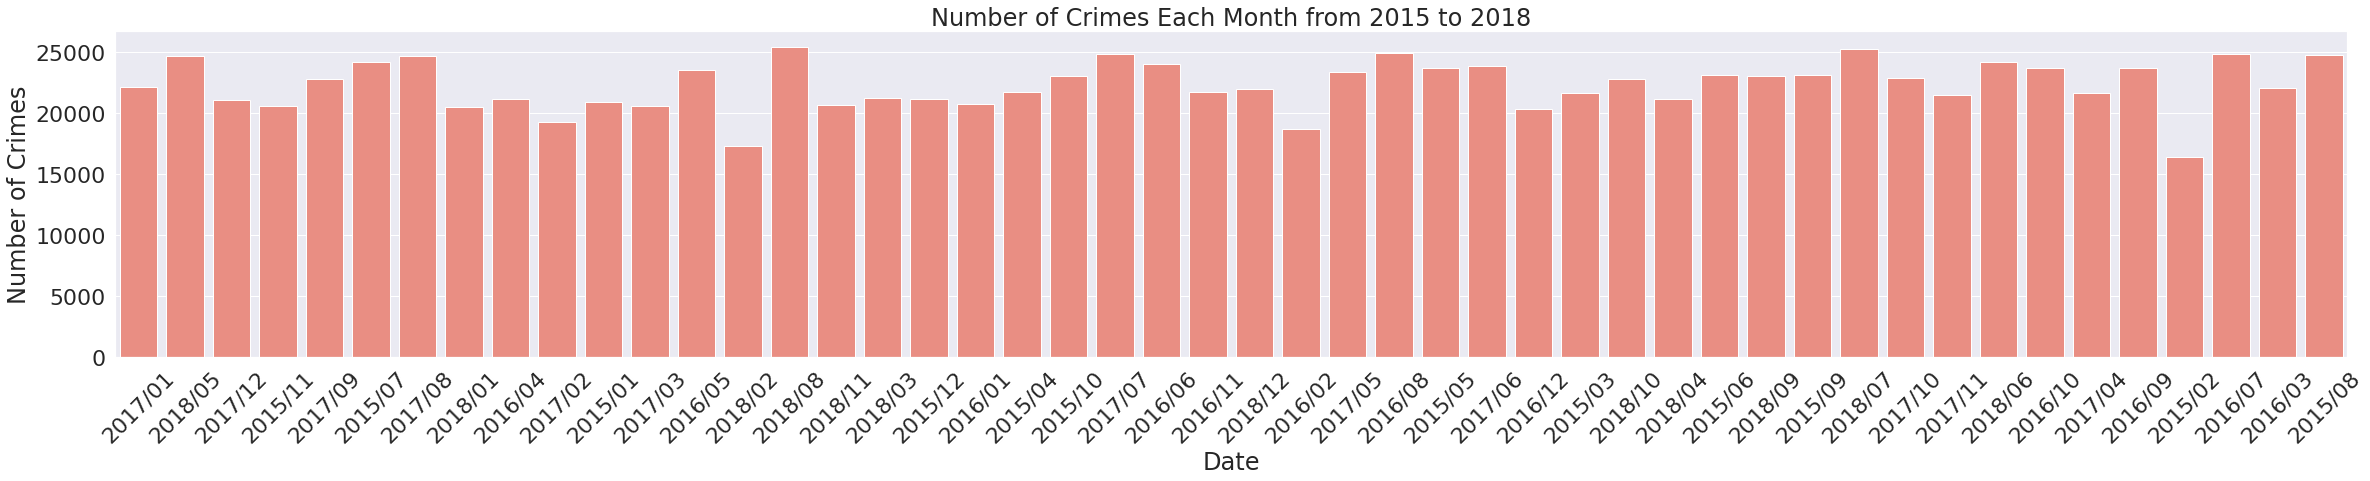

In [0]:
crimePerMonthPerYear_pd = crimePerMonthPerYear.toPandas()
sns.set(rc = {'figure.figsize':(40, 6)}, font_scale = 2)
sns.barplot(x = 'Year/Month', y = 'count', color = 'Salmon', 
            dodge = False, data = crimePerMonthPerYear_pd).set(title = 'Number of Crimes Each Month from 2015 to 2018')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.xticks(rotation = 45)
plt.show()

In [0]:
crimePerMonth = df.groupBy('Year','Month').count().groupby('Month').agg(f.mean('count').alias('average')).orderBy('Month')
crimePerMonth.show(5)

+-----+------------------+
|Month|           average|
+-----+------------------+
|    1|23896.909090909092|
|    2|21011.363636363636|
|    3|24608.363636363636|
|    4| 25859.14285714286|
|    5|29565.428571428572|
+-----+------------------+
only showing top 5 rows



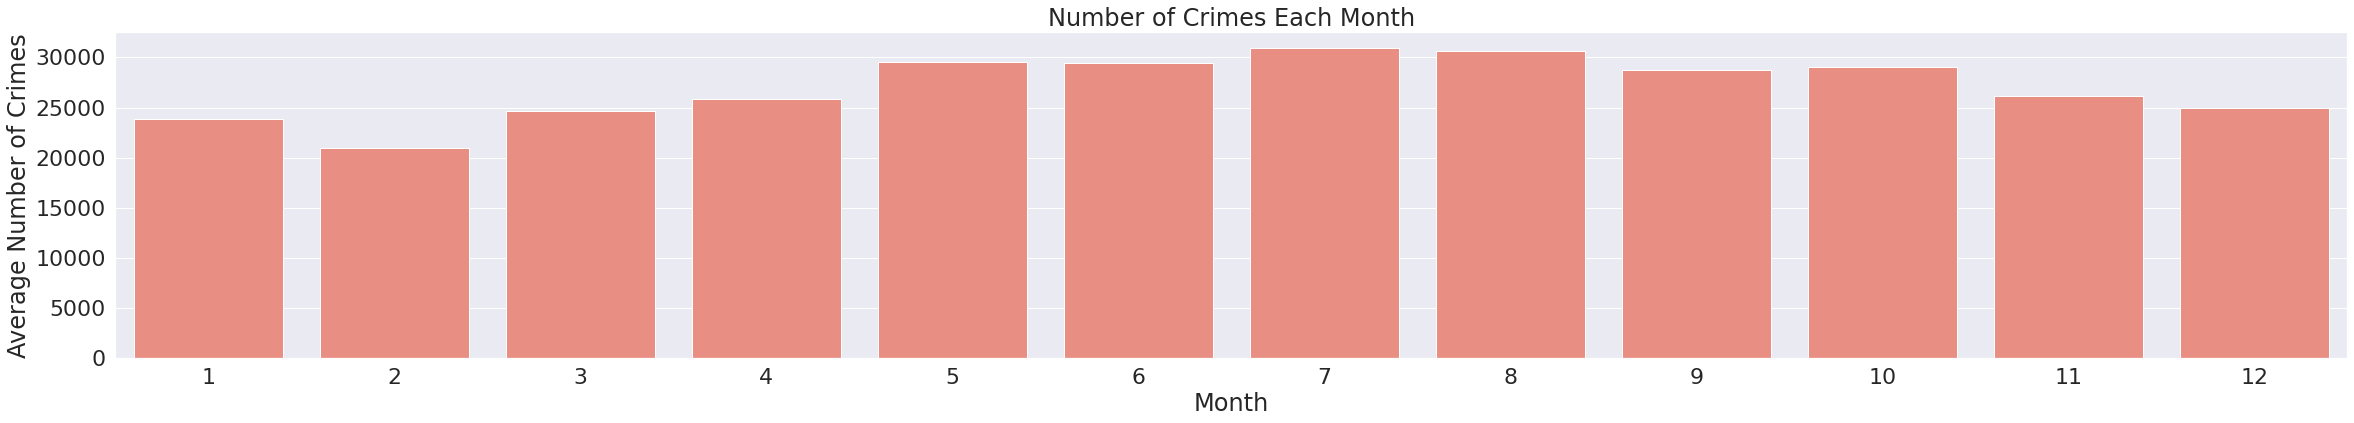

In [0]:
crimePerMonth_pd = crimePerMonth.toPandas()
sns.set(rc = {'figure.figsize':(40, 6)}, font_scale = 2)
sns.barplot(x = 'Month', y = 'average', color = 'Salmon', 
            dodge = False, data = crimePerMonth_pd).set(title = 'Number of Crimes Each Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Crimes')
plt.show()

We also analyzed the number of crimes with respsect to each hour in a certian day.
1. We illustrate the average and median number of crimes per day for each hour in a given day to see how crimes are distributed across a day. The average and median are pretty consistent. We can see that crime cases are very low before dawn time (5 am or 6 am) and begins to increase in the morning and reaches to the peak at noon. The numbers drops a little afterwards and stay at a pretty high level towards midnight. This is a high-level result, and the behavior might be quite different at a more granular level (for different community area, different crime type or different season). 
2. To ensure travel safety, one can pull the data from the time that she or he will travel and perform similar analysis. For example, if one wants to travel to Chicago in September and stay at area A, he can find the historical (or more recent years) average in September at area A for each hour.

In [0]:
import pyspark.sql.functions as f
crimePerHourPerDay = df.groupby('Day','Hour').count()
crimeAggPerHour = crimePerHourPerDay.groupby('Hour').agg(f.mean('count').alias('average'), f.percentile_approx('count', 0.5).alias('median')).orderBy('Hour')

In [0]:
crimeAggPerHour.show(5)

+----+------------------+------+
|Hour|           average|median|
+----+------------------+------+
|   0| 50.87291013584117|    46|
|   1| 29.17280149912997|    27|
|   2| 24.77147094512606|    22|
|   3|20.143282773564465|    17|
|   4|  15.2583615436696|    13|
+----+------------------+------+
only showing top 5 rows



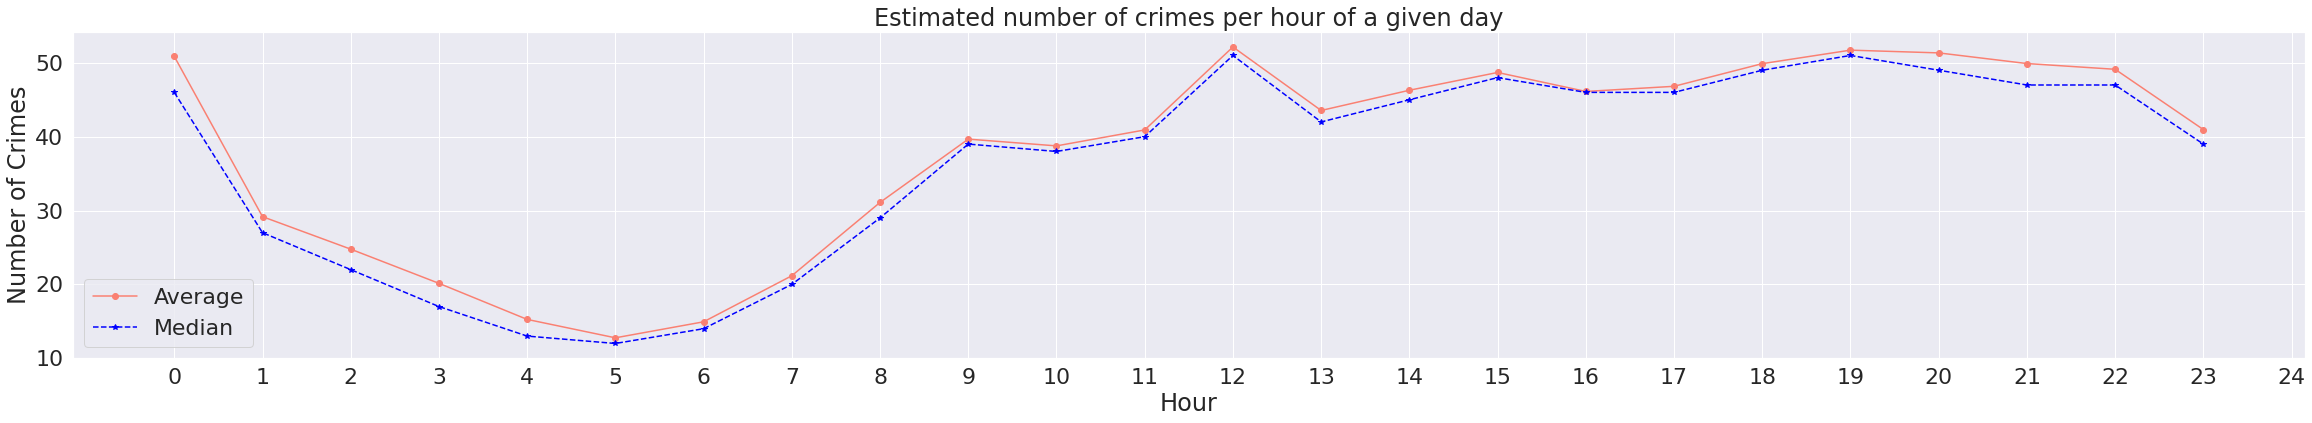

In [0]:
crimeAggPerHour_pd = crimeAggPerHour.toPandas()
plt.plot(crimeAggPerHour_pd['Hour'], crimeAggPerHour_pd['average'], color = 'salmon', label = 'Average', marker = 'o')
plt.plot(crimeAggPerHour_pd['Hour'], crimeAggPerHour_pd['median'], color = 'blue', label = 'Median', marker = '*', linestyle = 'dashed')
plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.title('Estimated number of crimes per hour of a given day')
plt.legend()
plt.xticks(np.arange(0, 25))
plt.show()

We analyzed the crime distribution w.r.t category and hour of top 3 dangerous areas. 
1. The top 3 dangerous communities in terms of total number of crime cases are Austin, North Side and South Shore, for each of these communities, we find out the hour (peak hour) that witnesses the most crime cases for each crime categories. Given there are too many crime categories, we only include those that have total crime cases larger than 200,000. 
2. This analysis gives good insights about how to distribute the police. For example, narcotics police should be well prepared at around 7pm each day at Austin as this is the time when drug dealers are most active in this area based on our analysis.

In [0]:
df = df.withColumnRenamed('Primary Type', 'Crime_Category')
df.createOrReplaceTempView("db_crime")
top3_tbl = spark.sql("""
                        select Community, Crime_Category, Hour as Peak_Hour, Number_Crimes                                   
                        from                                                                         
                        (select Community, Crime_Category, Hour, Number_Crimes,                                 
                        dense_rank() over(partition by Community, Crime_Category order by Number_Crimes desc) as rnk 
                        from                                                                         
                        (select count(*) as Number_Crimes, Community, Crime_Category, Hour                      
                        from db_crime                                                                
                        where Community in ('AUSTIN', 'NEAR NORTH SIDE', 'SOUTH SHORE') and
                        Crime_Category in 
                        (select Crime_Category from db_crime group by 1 having count(*) > 200000)
                        group by 2, 3, 4) as t ) as p                                                   
                        where rnk = 1
                        """)

In [0]:
display(top3_tbl)

Community Crime_Category Peak_Hour Number_Crimes AUSTIN ASSAULT 15 1801 AUSTIN BATTERY 21 4926 AUSTIN BURGLARY 12 1015 AUSTIN CRIMINAL DAMAGE 0 2548 AUSTIN DECEPTIVE PRACTICE 9 1826 AUSTIN MOTOR VEHICLE THEFT 22 1285 AUSTIN NARCOTICS 19 7649 AUSTIN OTHER OFFENSE 12 1795 AUSTIN ROBBERY 22 1176 AUSTIN THEFT 12 4095 NEAR NORTH SIDE ASSAULT 15 598 NEAR NORTH SIDE BATTERY 2 2971 NEAR NORTH SIDE BURGLARY 18 350 NEAR NORTH SIDE CRIMINAL DAMAGE 0 1176 NEAR NORTH SIDE DECEPTIVE PRACTICE 0 2141 NEAR NORTH SIDE MOTOR VEHICLE THEFT 18 366 NEAR NORTH SIDE NARCOTICS 21 1036 NEAR NORTH SIDE OTHER OFFENSE 9 672 NEAR NORTH SIDE ROBBERY 3 579 NEAR NORTH SIDE THEFT 17 7457 SOUTH SHORE ASSAULT 15 1044 SOUTH SHORE BATTERY 22 2833 SOUTH SHORE BURGLARY 8 1131 SOUTH SHORE CRIMINAL DAMAGE 22 1668 SOUTH SHORE DECEPTIVE PRACTICE 9 1153 SOUTH SHORE MOTOR VEHICLE THEFT 22 730 SOUTH SHORE NARCOTICS 20 1751 SOUTH SHORE OTHER OFFENSE 12 1116 SOUTH SHORE ROBBERY 21 692 SOUTH SHORE THEFT 12 2646

In [0]:
top3_tbl_pd = top3_tbl.toPandas()

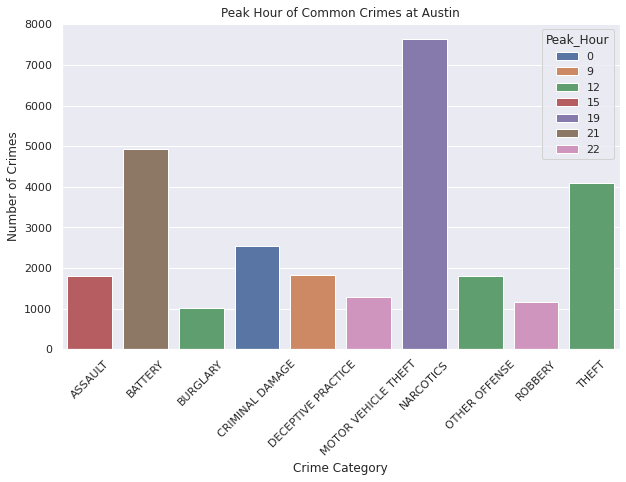

In [0]:
sns.set(rc = {'figure.figsize':(10, 6)})
austin_pd = top3_tbl_pd[top3_tbl_pd['Community'] == 'AUSTIN']
sns.barplot(x = 'Crime_Category', y = 'Number_Crimes', hue = 'Peak_Hour', 
                dodge = False, data = austin_pd).set(title = 'Peak Hour of Common Crimes at Austin')
plt.xlabel('Crime Category')
plt.ylabel('Number of Crimes')
plt.xticks(rotation = 45)
plt.show()

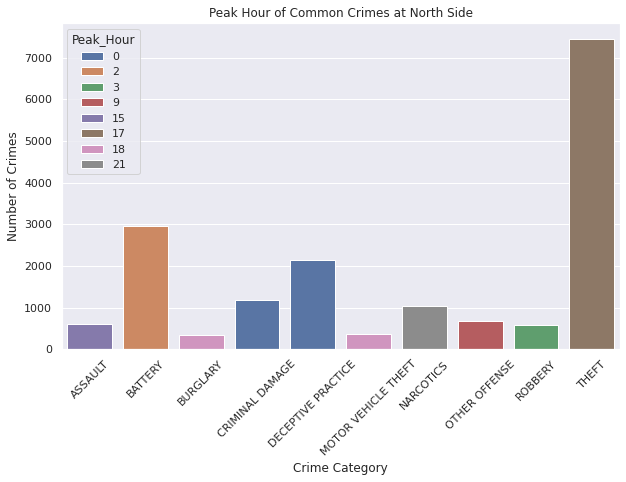

In [0]:
sns.set(rc = {'figure.figsize':(10, 6)})
northside_pd = top3_tbl_pd[top3_tbl_pd['Community'] == 'NEAR NORTH SIDE']
sns.barplot(x = 'Crime_Category', y = 'Number_Crimes', hue = 'Peak_Hour', 
                dodge = False, data = northside_pd).set(title = 'Peak Hour of Common Crimes at North Side')
plt.xlabel('Crime Category')
plt.ylabel('Number of Crimes')
plt.xticks(rotation = 45)
plt.show()

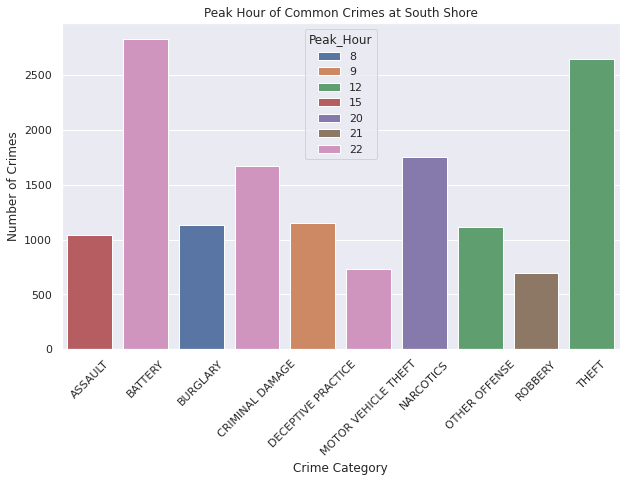

In [0]:
sns.set(rc = {'figure.figsize':(10, 6)})
southshore_pd = top3_tbl_pd[top3_tbl_pd['Community'] == 'SOUTH SHORE']
sns.barplot(x = 'Crime_Category', y = 'Number_Crimes', hue = 'Peak_Hour', 
                dodge = False, data = southshore_pd).set(title = 'Peak Hour of Common Crimes at South Shore')
plt.xlabel('Crime Category')
plt.ylabel('Number of Crimes')
plt.xticks(rotation = 45)
plt.show()

For different category of crime, we want to find the percentage of resolution.
We included only those categories of total number of crime cases larger than 50,000 and calculate the percentage of cases that were resolved (arrested) for each category. The chart below is ordered by the total number of crime cases for a given category (from high to low). We can observe that for certain common crime cases with small impact, such as theft, criminal damage, battery, the resolution rate is significantly low, probably due to limited evidence collected that can lead to the suspects. Resolution rate is relatively high for those "bigger" cases, especially narcotics, criminal trepass and weapon violation. For prostitution, I believe it is because suspects were easy to target for such cases.

In [0]:
from pyspark.sql.functions import round
udf_resolved = udf(lambda x: 1 if x == True else 0)
df = df.withColumn('Resolved', udf_resolved('Arrest').cast('int'))
crimeResolved = df.groupBy('Crime_Category').sum('Resolved').withColumnRenamed('sum(Resolved)', 'sum')
crimeResolution = crimeType.join(crimeResolved, crimeType['Primary Type'] == crimeResolved['Crime_Category'], 'inner')
crimeResolution = crimeResolution.withColumn('Resolution %', round(crimeResolution['sum']*100/crimeResolution['count']))
crimeResolution.show(5)

+--------------------+-----+--------------------+-----+------------+
|        Primary Type|count|      Crime_Category|  sum|Resolution %|
+--------------------+-----+--------------------+-----+------------+
|OFFENSE INVOLVING...|50619|OFFENSE INVOLVING...| 9764|        19.0|
|CRIMINAL SEXUAL A...| 4656|CRIMINAL SEXUAL A...|  357|         8.0|
|            STALKING| 4004|            STALKING|  554|        14.0|
|PUBLIC PEACE VIOL...|48062|PUBLIC PEACE VIOL...|31445|        65.0|
|           OBSCENITY|  732|           OBSCENITY|  580|        79.0|
+--------------------+-----+--------------------+-----+------------+
only showing top 5 rows



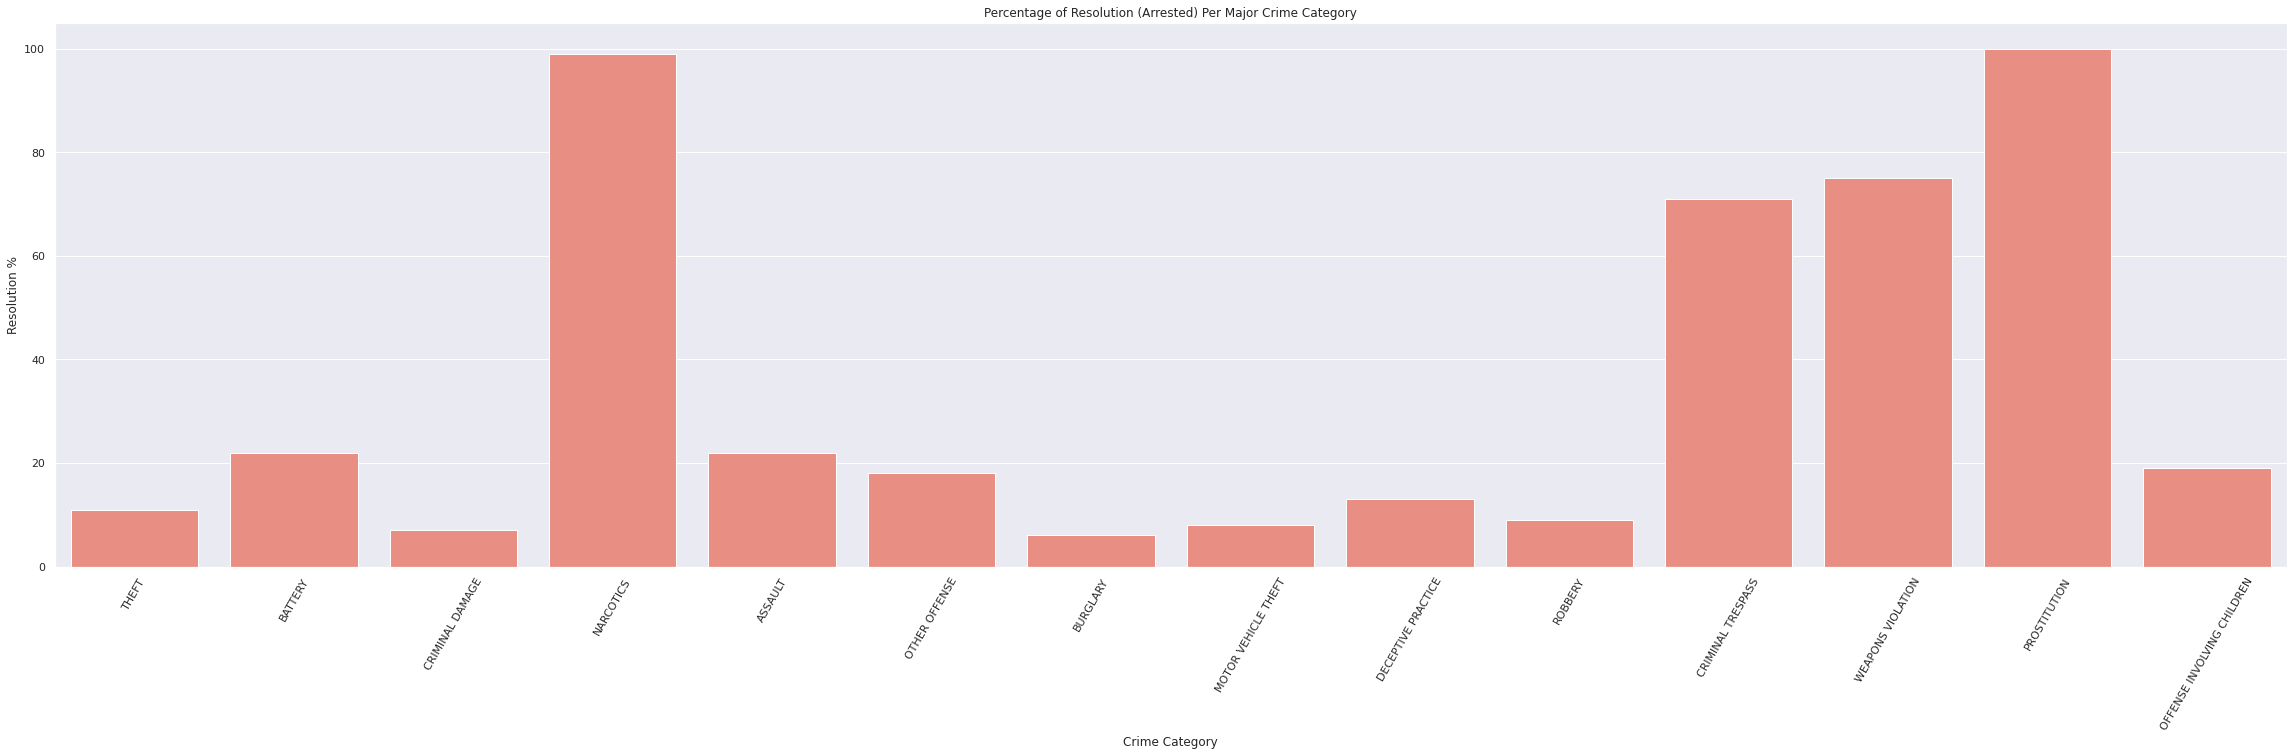

In [0]:
crimeResolution = crimeResolution.filter(crimeResolution['count'] > 50000).orderBy('count', ascending = False)
crimeResolution_pd = crimeResolution.toPandas()

sns.set(rc = {'figure.figsize':(40, 10)})
sns.barplot(x = 'Crime_Category', y = 'Resolution %', color = 'Salmon',
            data = crimeResolution_pd).set(title = 'Percentage of Resolution (Arrested) Per Major Crime Category')
plt.xlabel('Crime Category')
plt.xticks(rotation = 60)
plt.show()

#### 3.Clustering Spatial Data

In [0]:
# Perform spatial clustering based on latitude and longitude
df_spatial = df.select(['Latitude','Longitude'])
df_spatial.count()

Out[18]: 6893314

In [0]:
# Drop missing values
df_spatial = df_spatial.dropna()
df_spatial.count()

Out[19]: 6824471

In [0]:
# Remove outliers as clustering algorithm tends to be sensitive to outliers. We define outliers as those that are 
# outside the inter-quantile range.
quantiles = df_spatial.approxQuantile(['Latitude','Longitude'], [0.25, 0.75], 0)

lat_q1, lat_q3 = quantiles[0][0], quantiles[0][1]
lon_q1, lon_q3 = quantiles[1][0], quantiles[1][1]
lat_upper = lat_q3 + 1.5*(lat_q3 - lat_q1)
lat_lower = lat_q1 - 1.5*(lat_q3 - lat_q1)
lon_upper = lon_q3 + 1.5*(lon_q3 - lon_q1)
lon_lower = lon_q1 - 1.5*(lon_q3 - lon_q1)
outlier_filter = (df_spatial['Latitude'] >= lat_lower)&(df_spatial['Latitude'] <= lat_upper)&\
                 (df_spatial['Longitude'] >= lon_lower)&(df_spatial['Longitude'] <= lon_upper)
df_spatial = df_spatial.filter(outlier_filter)

In [0]:
df_spatial.show(5)

+------------+-------------+
|    Latitude|    Longitude|
+------------+-------------+
|41.815117282|-87.669999562|
|41.895080471|-87.765400451|
|41.937405765|-87.716649687|
|41.881903443|-87.755121152|
|41.744378879|-87.658430635|
+------------+-------------+
only showing top 5 rows



In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols = ['Latitude', 'Longitude'], outputCol = "features")
df_kmeans = vecAssembler.transform(df_spatial)

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol = 'prediction', featuresCol = 'features',
                                metricName = 'silhouette', distanceMeasure = 'squaredEuclidean')
# find the optimal number of clusters based on silhouette score
for i in range(2,8):
    kmeans = KMeans(featuresCol = 'features', k = i, seed = 1)
    model = kmeans.fit(df_kmeans)
    output = model.transform(df_kmeans)
    score = evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score with k = " + str(i) + ": " + str(score))

Silhouette Score with k = 2: 0.7222954984730067
Silhouette Score with k = 3: 0.5335862853818243
Silhouette Score with k = 4: 0.5678116574019108
Silhouette Score with k = 5: 0.5400609273245054
Silhouette Score with k = 6: 0.5447356878170112
Silhouette Score with k = 7: 0.5763484693112488


In [0]:
# k = 2 yields the best cost
# fig, ax = plt.subplots(1, 1, figsize =(8, 6))
# ax.plot(range(2, 8), silhouette_score)
# ax.set_xlabel("k")
# ax.set_ylabel("score")
# plt.show()

In [0]:
kmeans = KMeans(featuresCol = 'features', k = 2, seed = 1)
model = kmeans.fit(df_kmeans)
output = model.transform(df_kmeans).select('Latitude','Longitude','prediction')
centers = model.clusterCenters()
X_pos = [p[0] for p in centers]
Y_pos = [p[1] for p in centers]

In [0]:
output_pd = output.toPandas()

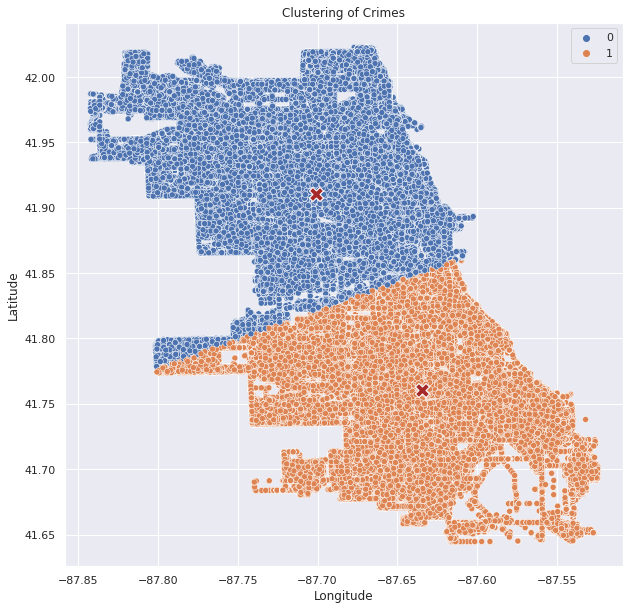

In [0]:
sns.set(rc = {'figure.figsize':(10, 10)})
sns.scatterplot(x = 'Longitude', y = 'Latitude', hue = 'prediction',
            data = output_pd).set(title = 'Clustering of Crimes')
sns.scatterplot(x = Y_pos, y = X_pos, s = 200, color = 'brown', marker = 'X')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [0]:
# let's try using 7 clusters
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols = ['Latitude', 'Longitude'], outputCol = "features")
df_kmeans = vecAssembler.transform(df_spatial)

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol = 'prediction', featuresCol = 'features',
                                metricName = 'silhouette', distanceMeasure = 'squaredEuclidean')

kmeans = KMeans(featuresCol = 'features', k = 7, seed = 1)
model = kmeans.fit(df_kmeans)
output = model.transform(df_kmeans).select('Latitude','Longitude','prediction')
centers = model.clusterCenters()
X_pos = [p[0] for p in centers]
Y_pos = [p[1] for p in centers]

In [0]:
output_pd = output.toPandas()

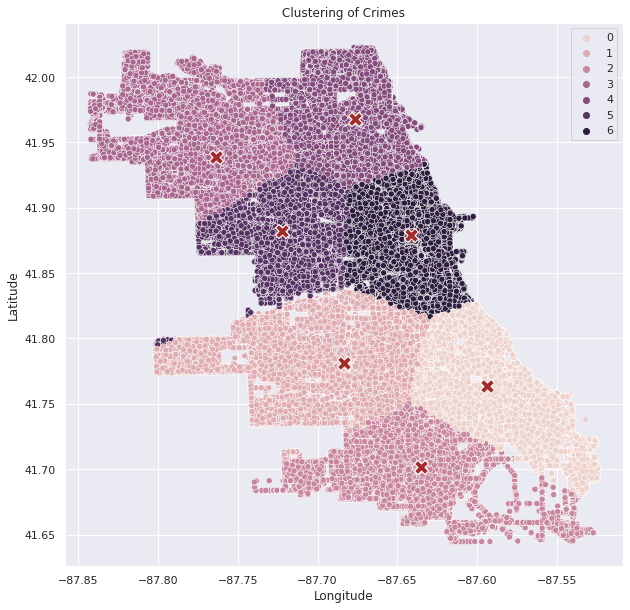

In [0]:
# the centers now make more sense, we want to know what community these centers belong to
sns.set(rc = {'figure.figsize':(10, 10)})
sns.scatterplot(x = 'Longitude', y = 'Latitude', hue = 'prediction',
            data = output_pd).set(title = 'Clustering of Crimes')
sns.scatterplot(x = Y_pos, y = X_pos, s = 200, color = 'brown', marker = 'X')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [0]:
df_geo_pd = df_geo_full.toPandas()

In [0]:
import numpy as np
def sjoin_helper(s, centers, show_centers = False):
  # slice the spatial data to remove leading characters MULTIPOLYGON
  s = s[13: ] + ','
  
  # manually split latitude and longitude values and store them in list
  lat_list = []
  lon_list = []
  i = j = 0
  while j < len(s):
    if s[j] == ' ' and j > i:
      lon_list.append(float(s[i: j]))
      i = j + 1
    if s[j] == ',':
      lat_list.append(float(s[i: j]))
      i = j + 2
    j += 1
  
  lat_pos = [p[0] for p in centers]
  lon_pos = [p[1] for p in centers]
  
  assert len(lat_list) == len(lon_list), 'Number of coordinates do not match!'
  N = len(lat_list)
  for k in range(len(centers)):
    found = False
    for i in range(N):
      lat1, lon1 = lat_list[i], lon_list[i]
      if i == N - 1:
        lat2, lon2 = lat_list[0], lon_list[0] # pairwise check for the closed region 
      else:
        lat2, lon2 = lat_list[i + 1], lon_list[i + 1]
      # first ensure the point is within the rectangular region formed by lon1 and lon2
      # then ensure the point is at the inner side of the line formed by two given points in the multi-polygon
      # repeat this for consecutive pair of points in the multi-polygon and if the point is at the inner side for 
      # odd number of lines, the point is within the region, otherwise, the point is outside the region 
      # (this can be proved by mathematical induction).
      if ((lon_pos[k] <= lon1 and lon_pos[k] >= lon2) or (lon_pos[k] <= lon2 and lon_pos[k] >= lon1)) and lon1 != lon2:
        if (lat1 - lat2)*(lon_pos[k] - lon2)/(lon1 - lon2) + lat2 < lat_pos[k]:
          found = not found
    if found == True: 
      if show_centers: 
        return [lat_pos[k], lon_pos[k]]
      else:
        return True
  return None if show_centers else False 
      

In [0]:
# the the_geom variable needs to be cleaned before mapping, we remove all the '(' and ')' first.
df_geo_pd['the_geom'] = df_geo_pd['the_geom'].str.replace('(', '', regex = True).str.replace(')', '', regex = True)
df_geo_pd['center_found'] = df_geo_pd['the_geom'].map(lambda s: sjoin_helper(s, centers = centers))
df_geo_pd['center'] = df_geo_pd['the_geom'].map(lambda s: sjoin_helper(s, centers = centers, show_centers = True))

In [0]:
center_df = df_geo_pd[df_geo_pd['center_found'] == True][['center','COMMUNITY']]
center_df

center 
 COMMUNITY 
 
 
 
 
 5 
 [41.968282692631625, -87.67652098899919] 
 LINCOLN SQUARE 
 
 
 14 
 [41.938666115395876, -87.76353335997915] 
 PORTAGE PARK 
 
 
 26 
 [41.882497646301495, -87.7224423531289] 
 WEST GARFIELD PARK 
 
 
 28 
 [41.87895960749246, -87.64177493265281] 
 NEAR WEST SIDE 
 
 
 46 
 [41.70160857500726, -87.63514555218944] 
 ROSELAND 
 
 
 63 
 [41.7815471330586, -87.68380120489716] 
 CHICAGO LAWN 
 
 
 66 
 [41.76383961103854, -87.59401028886836] 
 GREATER GRAND CROSSING

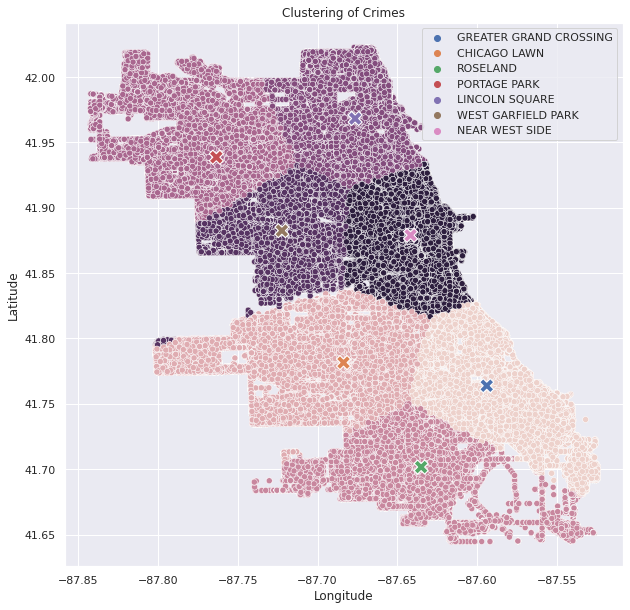

In [0]:
sns.set(rc = {'figure.figsize':(10, 10)})
sns.scatterplot(x = 'Longitude', y = 'Latitude', hue = 'prediction', legend = False,
            data = output_pd).set(title = 'Clustering of Crimes')
sns.scatterplot(x = Y_pos, y = X_pos, s = 200, color = 'brown', hue = ['GREATER GRAND CROSSING','CHICAGO LAWN','ROSELAND',
                                                                       'PORTAGE PARK','LINCOLN SQUARE','WEST GARFIELD PARK','NEAR WEST SIDE'], marker = 'X')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [0]:
crimeCommunity_pd = crimeCommunity_pd.reset_index()
crimeCommunity_pd['rank'] = crimeCommunity_pd['index'].map(lambda x: x + 1)
crimeCommunity_pd.drop('index', axis = 1, inplace = True)
crimeCommunity_pd.head()

center_df.merge(crimeCommunity_pd, left_on = 'COMMUNITY', right_on = 'Community')[['rank','Community','center','count']]

rank 
 Community 
 center 
 count 
 
 
 
 
 0 
 47 
 LINCOLN SQUARE 
 [41.968282692631625, -87.67652098899919] 
 48909 
 
 
 1 
 31 
 PORTAGE PARK 
 [41.938666115395876, -87.76353335997915] 
 87223 
 
 
 2 
 19 
 WEST GARFIELD PARK 
 [41.882497646301495, -87.7224423531289] 
 130814 
 
 
 3 
 5 
 NEAR WEST SIDE 
 [41.87895960749246, -87.64177493265281] 
 206031 
 
 
 4 
 10 
 ROSELAND 
 [41.70160857500726, -87.63514555218944] 
 183726 
 
 
 5 
 13 
 CHICAGO LAWN 
 [41.7815471330586, -87.68380120489716] 
 168984 
 
 
 6 
 12 
 GREATER GRAND CROSSING 
 [41.76383961103854, -87.59401028886836] 
 171249

#### 4. Feature Engineering
City of Chicago is the home of my universities, including University of Chicago, University of Illinois - Chicago (UIC), DePaul University, Loyola University, etc. We performed feature engineering to help analyze the crime behavior within each university region.

###### 4.1 Obtain the polygon coordinates of each school.

In [0]:
uofchicago = [(-87.6060948,41.7949287),
(-87.6069102,41.7846255),
(-87.586697,41.7834735),
(-87.5893578,41.7956006),
(-87.6060948,41.7949287)]
uic = [(-87.6509061,41.8623139),
(-87.6456275,41.8628252),
(-87.6473441,41.8763433),
(-87.6839938,41.8738189),
(-87.6829639,41.8666285),
(-87.6536098,41.8664687),
(-87.6509061,41.8623139)]
depaul_lincolnpark = [(-87.6612241,41.9259387),
(-87.6627262,41.921181),
(-87.648371,41.9217877),
(-87.6490576,41.9264975),
(-87.6612241,41.9259387)]
depaul_loop = [(-87.6278426,41.8795332),
 (-87.6278855,41.876953),
 (-87.6276173,41.8732702),
 (-87.6244952,41.8730785),
 (-87.6243236,41.879701),
 (-87.6278426,41.8795332)]
loyola_lakeshore = [(-87.6608551,42.0028906),
 (-87.6611341,41.9940562),
 (-87.6554693,41.994439),
 (-87.6545251,41.9952045),
 (-87.6550187,41.9986171),
 (-87.6564563,42.0024442),
 (-87.6608551,42.0028906)]
loyola_watertower = [(-87.6282522,41.8983943),
 (-87.62844,41.8966813),
 (-87.6241753,41.8965375),
 (-87.6239714,41.8986019),
 (-87.6282522,41.8983943)]           

###### 4.2 Define a function to determine whether a crime case point is within a given school region.

In [0]:
# udf used to find out whether a crime case occurs within a given region
def sjoin_helper_new(s, school_region):
    assert len(school_region) > 3, 'multi-polygon should include at least 3 points!'
    if s == None: return False # handle missing values
    
    # manually split latitude and longitude values
    s = s[1:-1]
    i = j = 0
    while j < len(s):
      if s[j] == ',':
        lat_pos = float(s[i:j])
        i = j + 2
      j += 1
    lon_pos = float(s[i:j])
      
    N = len(school_region)
    found = False
    for i in range(N):
      lon1, lat1 = school_region[i][0], school_region[i][1]
      if i == N - 1:
        lon2, lat2 = school_region[0][0], school_region[0][1]  
      else:
        lon2, lat2 = school_region[i + 1][0], school_region[i + 1][1]
      if ((lon_pos <= lon1 and lon_pos >= lon2) or (lon_pos <= lon2 and lon_pos >= lon1)) and lon1 != lon2:
        if (lat1 - lat2)*(lon_pos - lon2)/(lon1 - lon2) + lat2 < lat_pos:
          found = not found
    return found 

###### 4.3 Create new features to aggregate the total crime counts of each school since 2017.
1. The results are summarized by each school in each year and by top crime category for each school. 
2. In general, we can see for all schools, crime counts in 2020 and 2021 are significantly less than crime counts in 2017, 2018 and 2019. 
3. Total crime counts of U of Chicago are significantly less that crime counts of UIC, DePaul and Loyola, probably because the campus of the last three schools are more spreaded across the city and covers larger regions. 
4. Top crime categories are pretty consistent among all schools.

In [0]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Crime_Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- AREA_NUMBE: integer (nullable = true)
 |-- COMMUNITY: string (nullable = true)
 |-- Day_st

In [0]:
df_school = df.filter(df['Year'] >= 2017).select(['Year', 'Crime_Category','Location'])

uofchicago_filter = udf(lambda s: sjoin_helper_new(s, school_region = uofchicago))
uic_filter = udf(lambda s: sjoin_helper_new(s, school_region = uic))
depaul_lincolnpark_filter = udf(lambda s: sjoin_helper_new(s, school_region = depaul_lincolnpark))
depaul_loop_filter = udf(lambda s: sjoin_helper_new(s, school_region = depaul_loop))
loyola_lakeshore_filter = udf(lambda s: sjoin_helper_new(s, school_region = loyola_lakeshore))
loyola_watertower_filter = udf(lambda s: sjoin_helper_new(s, school_region = loyola_watertower))

df_school = df_school.withColumn('UofChicago', uofchicago_filter('Location').cast('boolean'))
df_school = df_school.withColumn('UIC', uic_filter('Location').cast('boolean'))
df_school = df_school.withColumn('Depaul_LincolnPark', depaul_lincolnpark_filter('Location').cast('boolean'))
df_school = df_school.withColumn('Depaul_Loop', depaul_loop_filter('Location').cast('boolean'))
df_school = df_school.withColumn('Loyola_LakeShore', loyola_lakeshore_filter('Location').cast('boolean'))
df_school = df_school.withColumn('Loyola_WaterTower', loyola_watertower_filter('Location').cast('boolean'))

In [0]:
df_school_pd = df_school.toPandas()

In [0]:
df_school_pd.head()

Year 
 Crime_Category 
 Location 
 UofChicago 
 UIC 
 Depaul_LincolnPark 
 Depaul_Loop 
 Loyola_LakeShore 
 Loyola_WaterTower 
 
 
 
 
 0 
 2018 
 THEFT 
 None 
 False 
 False 
 False 
 False 
 False 
 False 
 
 
 1 
 2020 
 THEFT 
 (41.952051946, -87.754660372) 
 False 
 False 
 False 
 False 
 False 
 False 
 
 
 2 
 2018 
 DECEPTIVE PRACTICE 
 None 
 False 
 False 
 False 
 False 
 False 
 False 
 
 
 3 
 2019 
 DECEPTIVE PRACTICE 
 (41.852248185, -87.623786256) 
 False 
 False 
 False 
 False 
 False 
 False 
 
 
 4 
 2019 
 THEFT 
 (41.895732399, -87.687784384) 
 False 
 False 
 False 
 False 
 False 
 False

In [0]:
school_list = ['UofChicago','UIC','Depaul_LincolnPark','Depaul_Loop','Loyola_LakeShore','Loyola_WaterTower']
df_school_pd[school_list] = df_school_pd[school_list].astype('int')
df_school_pd['DePaul'] = df_school_pd['Depaul_LincolnPark'] + df_school_pd['Depaul_Loop']
df_school_pd['Loyola'] = df_school_pd['Loyola_LakeShore'] + df_school_pd['Loyola_WaterTower']

school_list_new = ['UofChicago','UIC','DePaul','Loyola']
df_schoolcrime_byyear = df_school_pd.groupby('Year').sum()[school_list_new].reset_index()
df_schoolcrime_bytype = df_school_pd.groupby('Crime_Category').sum()[school_list_new].reset_index()
df_schoolcrime = df_school_pd[school_list_new].sum()

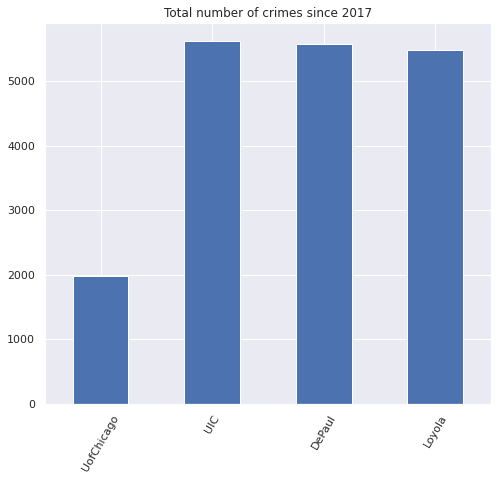

In [0]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = 8, 7
df_schoolcrime.plot.bar()
plt.xticks(rotation = 60)
plt.title('Total number of crimes since 2017')
plt.show()

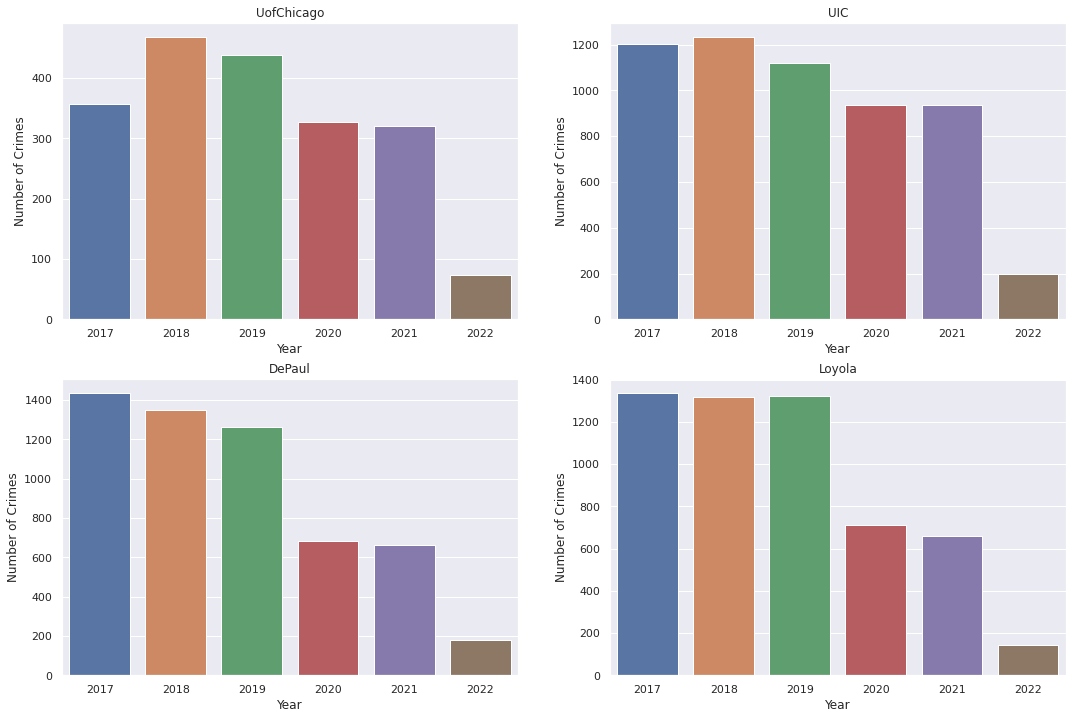

In [0]:
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
for i, school in enumerate(school_list_new):
  sns.barplot(x = 'Year', y = school, data = df_schoolcrime_byyear,
              ax = axes[i//2][i%2]).set(title = school)
  axes[i//2][i%2].set_ylabel('Number of Crimes')

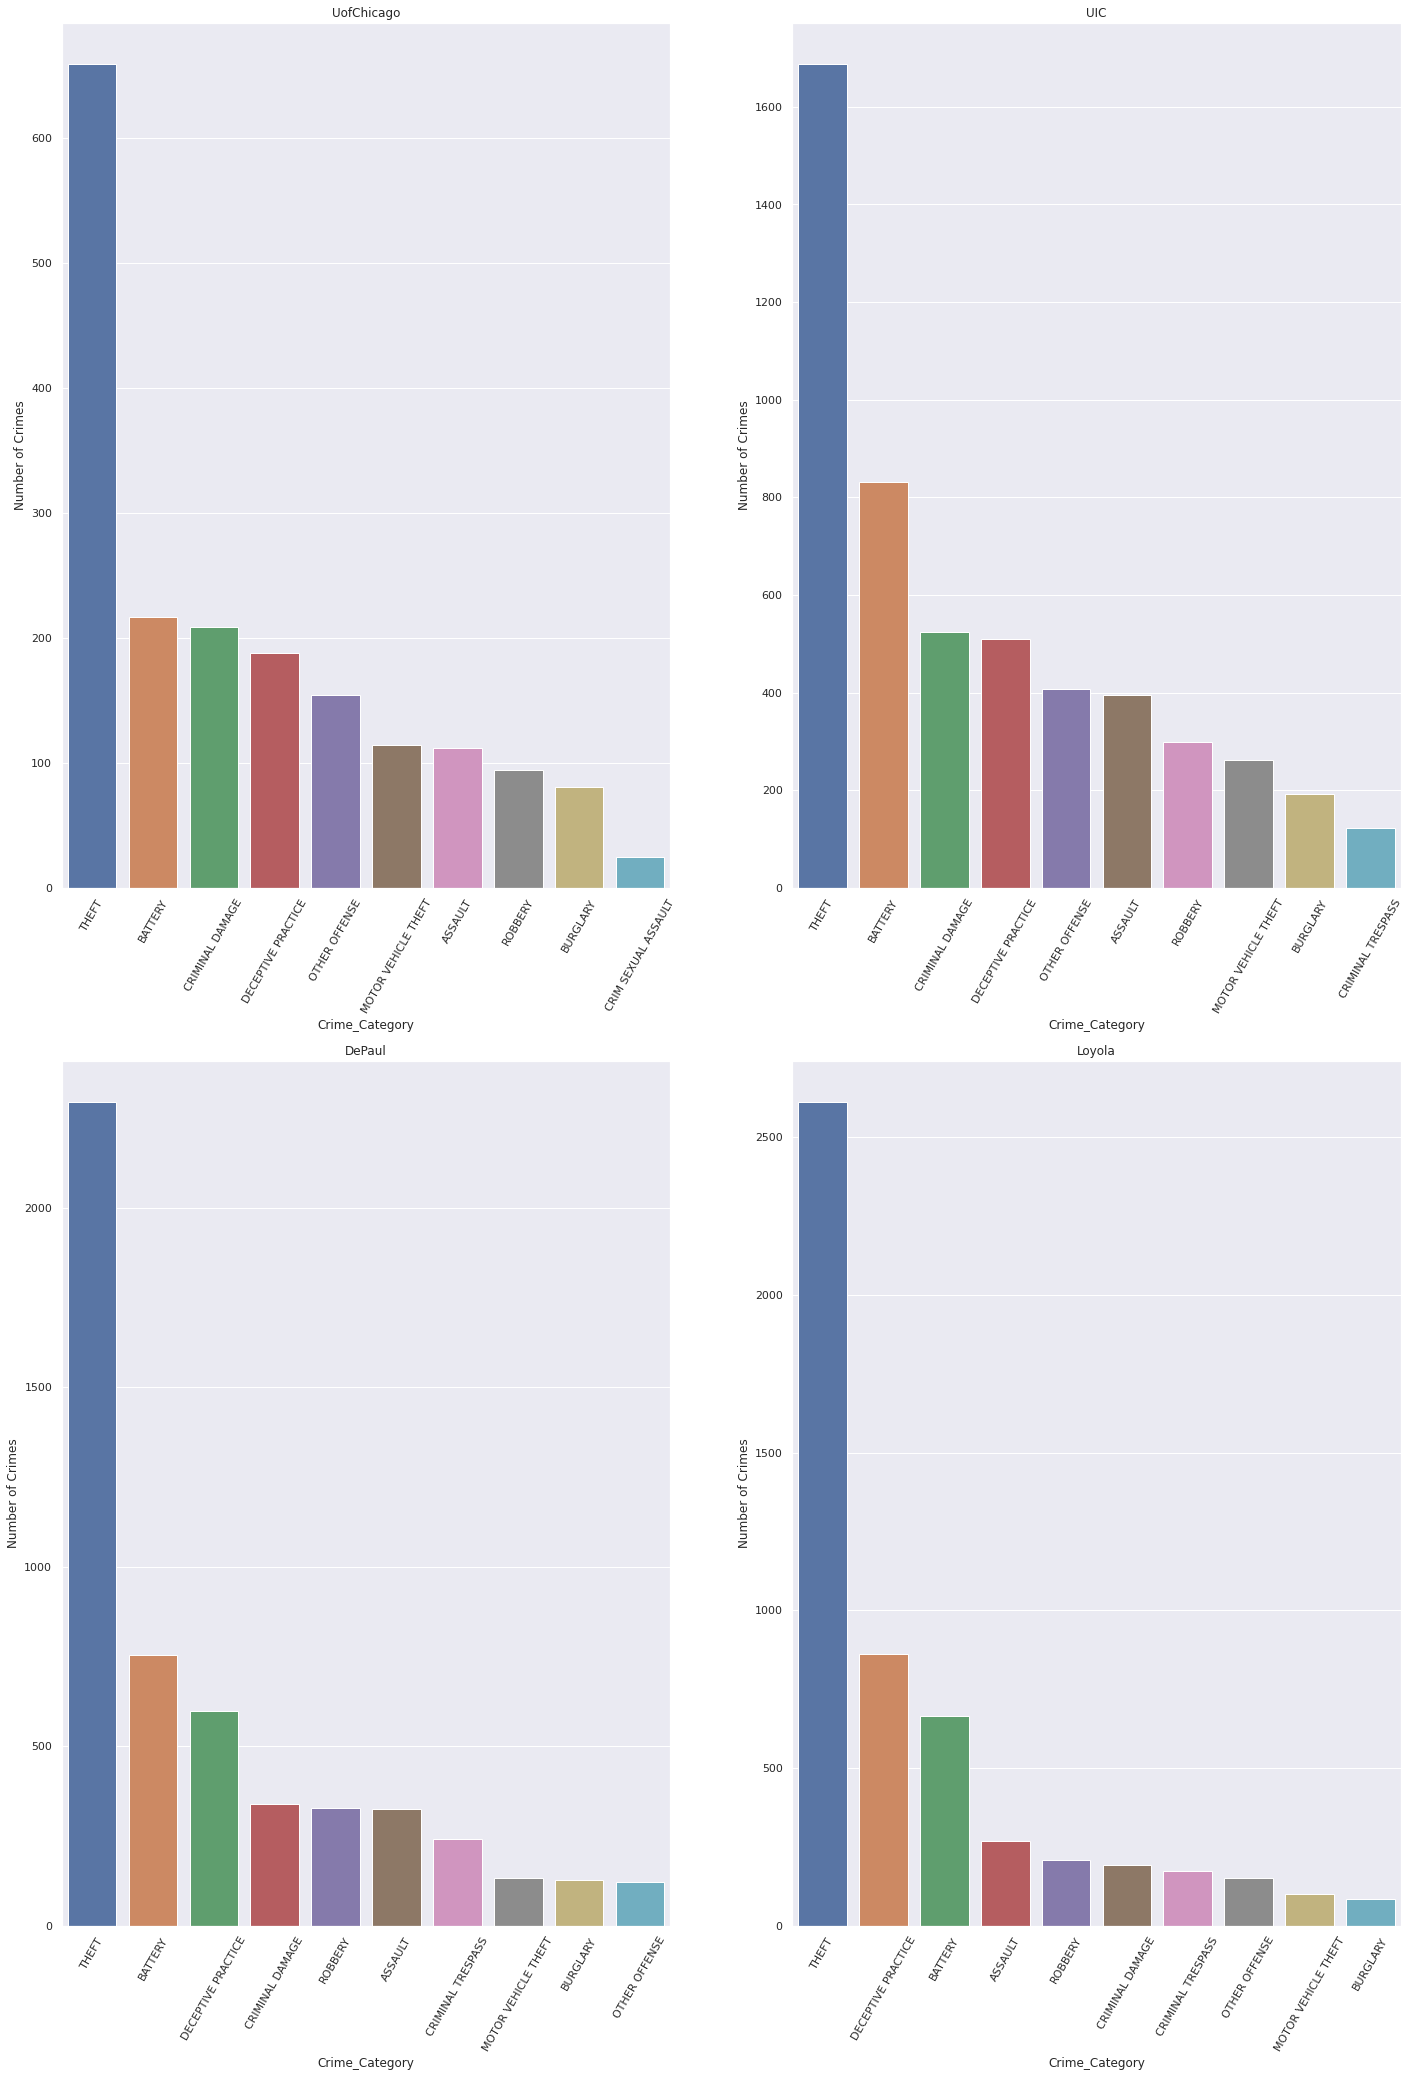

In [0]:
fig, axes = plt.subplots(2, 2, figsize = (24, 35))
for i, school in enumerate(school_list_new):
  data = df_schoolcrime_bytype.sort_values(by = school, ascending = False).iloc[:10,:]
  sns.barplot(x = 'Crime_Category', y = school, data = data,
              ax = axes[i//2][i%2]).set(title = school)
  axes[i//2][i%2].set_ylabel('Number of Crimes')
  axes[i//2][i%2].set_xticklabels(labels = data['Crime_Category'], rotation = 60)

#### 5. Time series analysis

###### 5.1 Data exploration and cleaning

In [0]:
ts_per_day = df.groupBy('Year/Month').count().orderBy('Year/Month')
ts_pd = ts_per_day.toPandas()
ts_pd['Time'] = pd.to_datetime(ts_pd['Year/Month'], format = '%Y-%m')
ts_pd = ts_pd.set_index('Time').drop('Year/Month', axis = 1)
ts_pd.index = pd.DatetimeIndex(ts_pd.index.values, freq = ts_pd.index.inferred_freq)

In [0]:
print(ts_pd.index)

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', length=255, freq='MS')


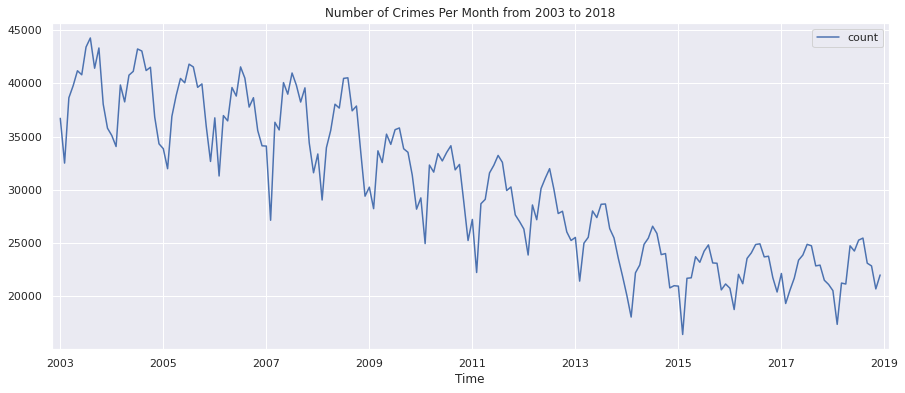

In [0]:
ts_train = ts_pd[(ts_pd.index >= '2003-01-01')&(ts_pd.index <= '2018-12-01')]
ts_train.plot(figsize = (15, 6))
plt.xlabel('Time')
plt.xlim(left = pd.to_datetime('2002-11-01'), right = pd.to_datetime('2019-02-01'))
plt.title('Number of Crimes Per Month from 2003 to 2018')
plt.show()

In [0]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

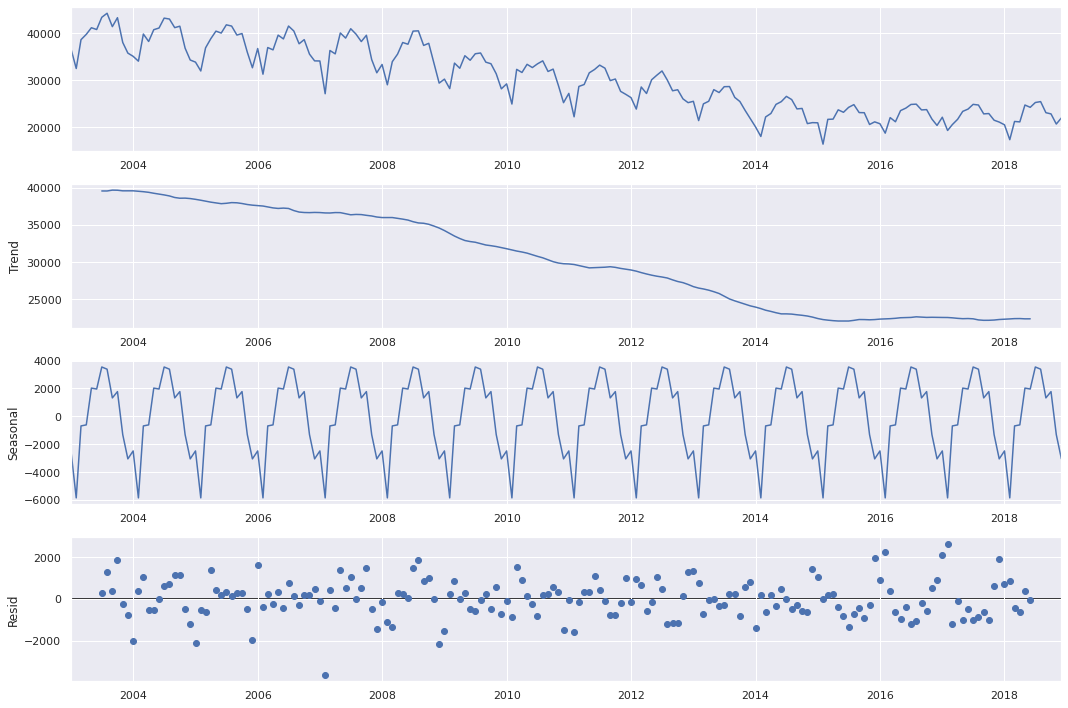

In [0]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = 15, 10
decomposition = sm.tsa.seasonal_decompose(ts_train, model='additive')
fig = decomposition.plot()
plt.show()

###### 5.2 SARIMA Model

In [0]:
import itertools
p = q = range(0, 3)
d = range(0, 2)
order_list = list(itertools.product(p, d, q))
seasonal_order_list = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(order_list)
print(seasonal_order_list)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12)]


In [0]:
params = {'order': None, 'seasonal_order': None}
best_aic = float('Inf')
for order in order_list:
  for seasonal_order in seasonal_order_list:
    model = sm.tsa.statespace.SARIMAX(ts_train, order = order, seasonal_order = seasonal_order, enforce_stationarity = False, enforce_invertibility = False)
    res = model.fit()
    aic = res.aic
    print('order = ' + str(order) + ' seasonal_order = ' + str(seasonal_order) + ' : aic = ' + str(aic))
    if aic < best_aic:
      best_aic = aic
      params['order'] = order
      params['seasonal_order'] = seasonal_order

order = (0, 0, 0) seasonal_order = (0, 0, 0, 12) : aic = 4495.574248841656
order = (0, 0, 0) seasonal_order = (0, 0, 1, 12) : aic = 4072.5094303632804
order = (0, 0, 0) seasonal_order = (0, 0, 2, 12) : aic = 3733.1357901459187
order = (0, 0, 0) seasonal_order = (0, 1, 0, 12) : aic = 3202.465716936342
order = (0, 0, 0) seasonal_order = (0, 1, 1, 12) : aic = 2977.1268590323407
order = (0, 0, 0) seasonal_order = (0, 1, 2, 12) : aic = 2759.9557635331203
order = (0, 0, 0) seasonal_order = (1, 0, 0, 12) : aic = 3125.114710076038
order = (0, 0, 0) seasonal_order = (1, 0, 1, 12) : aic = 3105.137475768801
order = (0, 0, 0) seasonal_order = (1, 0, 2, 12) : aic = 2905.3560664540173
order = (0, 0, 0) seasonal_order = (1, 1, 0, 12) : aic = 2984.4726439267215
order = (0, 0, 0) seasonal_order = (1, 1, 1, 12) : aic = 2968.7167348535895
order = (0, 0, 0) seasonal_order = (1, 1, 2, 12) : aic = 2747.7513286679405
order = (0, 0, 0) seasonal_order = (2, 0, 0, 12) : aic = 2918.3310003055203
order = (0, 0, 0

In [0]:
print(params)

{'order': (0, 1, 2), 'seasonal_order': (1, 1, 2, 12)}


###### 5.3 Model Diagnostics
The Ljung-Box test and Jarque-Bera test look good: the model does not lact of fit and the residuals pretty much follow white noise of normal distribution, which can also be confirmed by the diagnostic plots

In [0]:
model = sm.tsa.statespace.SARIMAX(ts_train, order = params['order'], seasonal_order = params['seasonal_order'], 
                                  enforce_stationarity = False, enforce_invertibility = False)
res = model.fit()
print(res.summary().tables[1])
print(res.summary().tables[2])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4990      0.084     -5.918      0.000      -0.664      -0.334
ma.L2         -0.1564      0.083     -1.887      0.059      -0.319       0.006
ar.S.L12       0.3425      0.117      2.939      0.003       0.114       0.571
ma.S.L12      -1.0256      0.129     -7.956      0.000      -1.278      -0.773
ma.S.L24       0.3135      0.086      3.638      0.000       0.145       0.482
sigma2      9.349e+05   1.01e+05      9.260      0.000    7.37e+05    1.13e+06
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.86   Prob(JB):                         0.46
Heteroskedasticity (H):               0.64   Skew:                             0.09
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.46


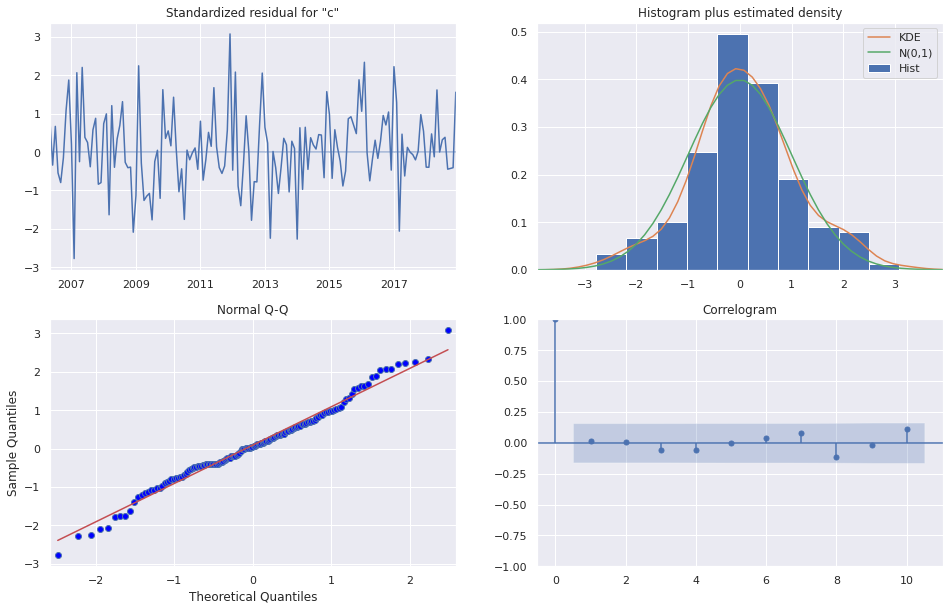

In [0]:
res.plot_diagnostics(figsize=(16, 10))
plt.show()

###### 5.4 Model Testing and Evaluation
1. We the predict the crime counts using the model for 2019 and onwards. The predicted series generates a pattern that is more correlated with the historical series that is close to it (2014 to 2019), therefore, the prediction error is small in 2019. However, the crime counts drop starting from 2020, which does not follow the pattern predicted by the model, therefore, the prediciton error becomes larger (notice that the predicted confidence level almost fall outside the true series). 
2. It is no doubt that the breakout of pandemic in 2020 contributes to the general drop in numbers of crimes, however, the way in which it correlates with the crime behavior should be studied at a more granular level using other methods, because the current time series model cannot predict idiosyncratic events, such as the pandemic, war, etc.

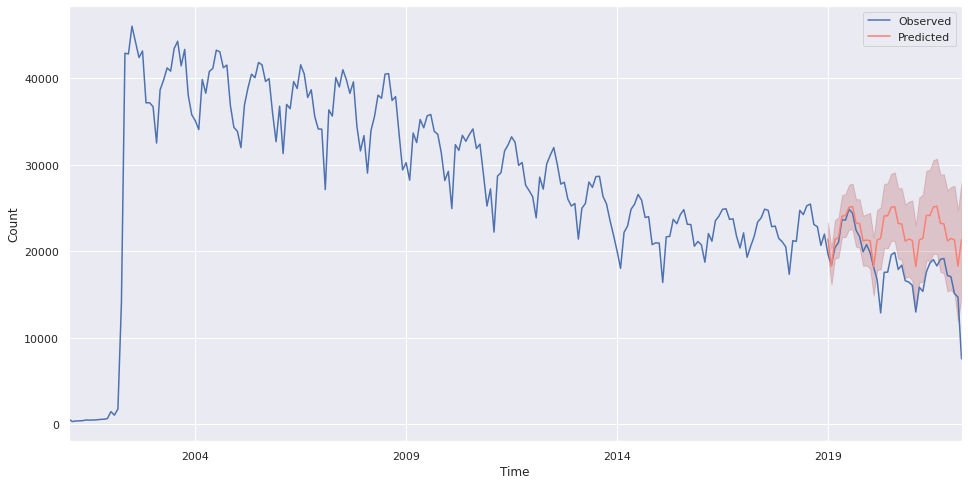

In [0]:
ts_test = ts_pd[ts_pd.index >= '2019-01-01']
test_period = ts_test.index
pred = res.get_prediction(start = test_period[0], end = test_period[-1], dynamic = False)
pred_value = pred.predicted_mean
pred_CI = pred.conf_int()

ax = ts_pd.plot(label = 'Observed', figsize = (16, 8))
pred_value.plot(ax = ax, label = 'Predicted', color = 'Salmon')
ax.fill_between(pred_CI.index, pred_CI.iloc[:,0], pred_CI.iloc[:,1], color = 'brown', alpha = 0.2)

ax.set_xlabel('Time')
ax.set_ylabel('Count')
plt.legend(['Observed','Predicted'], loc = 'best')
plt.show()

In [0]:
y_pred = pred_value.values
y_true = ts_pd['2019-01-01':].values

# Compute the mean square error
squared_diff = (y_pred - y_true)**2
mse = (squared_diff).mean()/squared_diff.std()
print('The Standardized mean squared error is ' + str(mse))

The Standardized mean squared error is 0.7156035243744373


### 6.Conclusion. 
We analyzed the crime data of Chicago city since 2001 and aimed at getting insights from the data about crime behavior from several perspectives. We performed OLAP through spark SQL and dataframe manipulation, visualization and K-means clustering. 
1. Theft, battery and criminal damage are the top 3 most frequent crime categories 
2. Austin, North Side and South Shore are considered as the top 3 most dangerous community areas in terms of total number of crime cases historically. 
3. We also observed clear seasonal pattern of crimes across different months over a year. In addition, we also see that crime behavior fluctuates over time within a day; crimes happens a lot at noon or in the midnight, and stays at a high level from 7pm to 11pm. The data can provide safety guidance for those who plan to travel to Chicago. One can see how often a certain crime category occurs at a give time at a given location. 
4. For the top 3 dangerous areas, we also identified the hour (peak hour) at which each crime category occurs the most frequently. This will provide insights about how to prepare and distribute law enforcement more effciently and allow them to act more promptly. 
5. We also determine the resolution rate for each type of crime. The results show that for crime category that has small impact, such as theft, battery and criminal damage, the resolution rate is very low, while cases such as narcotics, weapon violation, etc, which have large societal impact have high resolution rate. However, for cases such as robbery, burglary, offense involving children, etc., which have low resolution rate, should draw more of our attention. The reason behind this diverse ditribution of different resolution rates across crime category is complex and not uncommon. 
6. We performed K-means clustering for the geographic data for all crimes and tried to identified cluster centers. Silhouette methods suggested using k = 2 clusters, but the results showed two isolated clutsers that are quite apart, which does not make too much sense. This is because the algorithm is solely based on coordinates and just tries to pick the centers that can minimize the total distance. We then use k = 7 and the results are better. We created our own udf to facilitate a spatial join to identified the commnuity area that each center point belong to. Note that the identified community areas are not necessarily the top areas that see the most crime cases historically, because in K-means, we look at all cases globally instead of at each community area and find the centers that can better cluster all crime cases around them. 
7. We then perform feature engineering to analyze crime behavior in four major universities in Chicago: U of Chicago, UIC, DePaul and Loyala, by creating new variables to count the crimes cases that occurred in these school regions. 
8. Finally, we built seasonal ARIMA model to forecast the monthly crime count. 2019 to 2022 data is used as testing data. The prediction error is small in 2019 but large in 2020 onward. Based on our analysis, the large variance is due to the breakout of pandemic, which is an idiosyncratic event that is difficult to be predicted by the time series model.